# Ising Model Implementation with Quantum Computation Algorithm

All of the following quantum algorithm is developed based on qiskit.

In [1]:
# Import Modules
import numpy as np # Matehmatics Module
import random # Generate Random Numbers for Classic Methods
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile # Core Module for Quantum Computing
from qiskit_aer import Aer  # Qiskit module for simulation backends.
import matplotlib.pyplot as plt # Graphing Module
from time import time # Time Module for complexity comparison
import copy

In [2]:
# Several Functions for convenience

# A function that oragnize data in the form of a dictionary
def encode(dyctionary, intkey):
    strkey = str(intkey)
    if strkey in list(dyctionary.keys()):
        dyctionary[strkey] += 1
    else:
        dyctionary[strkey] = 1

# A function that presents the data in the dictionary with graphs
def plotdyct(inputdictionary):
    plt.bar(inputdictionary.keys(), inputdictionary.values())
    plt.xticks(ticks = list(inputdictionary.keys()), rotation = 270)

## 1D Ising Model (Without External Magnetic Field)

### Classic Monte Carlo Algorithm

The basic code of the classic algorithm is generatede by ChatGPT. I then modified a littel bit to change it into the form of a closed loop (in which case the tail is connteced to the head)

In [5]:
# Set up functions
def energy(spin, J):
    E = 0
    for i in range(0, len(spin)):
        E += spin[i-1] * spin[i]
    E = -J * E
    return E

def deltaE(spin, ind, J):
    temp = spin.copy()
    temp[ind] = temp[ind] * (-1)
    dE = energy(temp, J) - energy(spin, J)
    return dE

0.03775453567504883 seconds
{'[1, -1, -1, -1]': 250, '[-1, -1, -1, -1]': 499, '[1, 1, -1, -1]': 128, '[1, 1, 1, -1]': 67, '[1, 1, 1, 1]': 56}


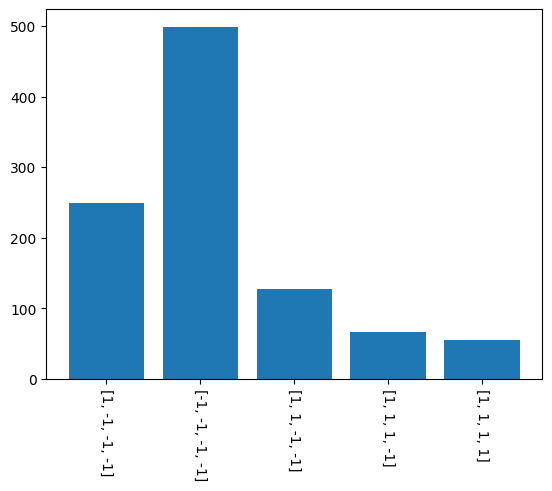

In [6]:
# Set up Main Functions
dyct = {}

N = 4
J = -0.25*np.log(0.5)
T = 1


start = time()

for j in range(1000):
    spins = [1, 1, 1, 1]
    for i in range(len(spins)):
        index = i
        if deltaE(spins, index, J) <= 0 or (deltaE(spins, index, J) > 0 and random.random() < np.exp(-deltaE(spins, index, J)/T)):
            spins[index] = spins[index] * (-1)
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plotdyct(dyct)

### Quantum (+ Classic) Algorithm

The code is developed with qiskit, based on the paper *An algorithm for simulating the Ising model on a type-II computer* written by J.H. Cole, L.C.L. Hollenberg, and S. Prawer, published in 2004 (Will be addressed as *2004 Paper* in the later part of this note). The following graph shows the construction of the circuit.

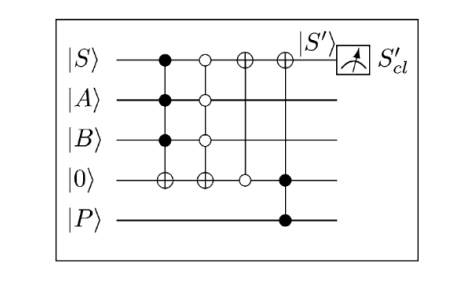

**Figure 1** *The graph is from the 2004 paper*

In the graph, S stands for the spin we are looking at. A and B stand for S's 2 neighbor spins. 0 is a scratch qubit used for stroing information temporaily, and P bring the information about flipping possibility.|

Notice that the symbol looks like a multilpe control not gate with hollow points stands for multiple control not gate detecing 0s, which means that the target qubit will be flipped if all the control qubits are 0. A more clearer illustration can be seen below:

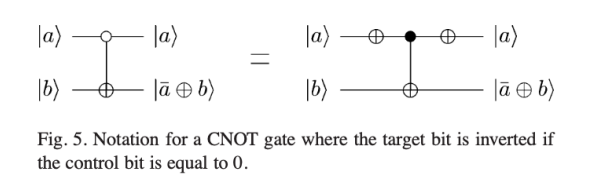

*The graph is from the 2004 paper*

Here's the explanation. First, for all 1-dimensional ising model systems, when we are deciding whether or not a spin should be flipped, we only need to pay attention to the spin itself and its two neighbors. This can be prove matehmatically. 

Suppose a system with n spins. We are looking at the mth one, where m<n. The energy of the system before and after the flip is:
$$
E_{before} = -J*(S_1*S_2+S_2*S_3+...+S_{m-1}*S_m+S_m*S_{m+1}+S_{m+1}*S_{m+2}+...+S_{n-1}*S_n+S_n*S_1) \\
E_{after} = -J*(S_1*S_2+S_2*S_3+...-S_{m-1}*S_m-S_m*S_{m+1}+S_{m+1}*S_{m+2}+...+S_{n-1}*S_n+S_n*S_1)
$$

The change of energy is:
$$
\Delta E_1 = -J*(-2S_{m-1}*S_m-2S_m*S_{m+1})
$$

which is exactly the same if we only consider the spin itself and its 2 neighbors:
$$
E_{before}' = -J*(S_{m-1}*S_m+S_m*S_{m+1}+S_{m+1}*S_{m-1}) \\
E_{after}' = -J*(-S_{m-1}*S_m-S_m*S_{m+1}+S_{m+1}*S_{m-1}) \\
\Delta E_2 = -J*(-2S_{m-1}*S_m-2S_m*S_{m+1})
$$

Since there are only 3 spins to consider, there exists eight situations in total. After lisitng and calculating all the situations, we get the table below:

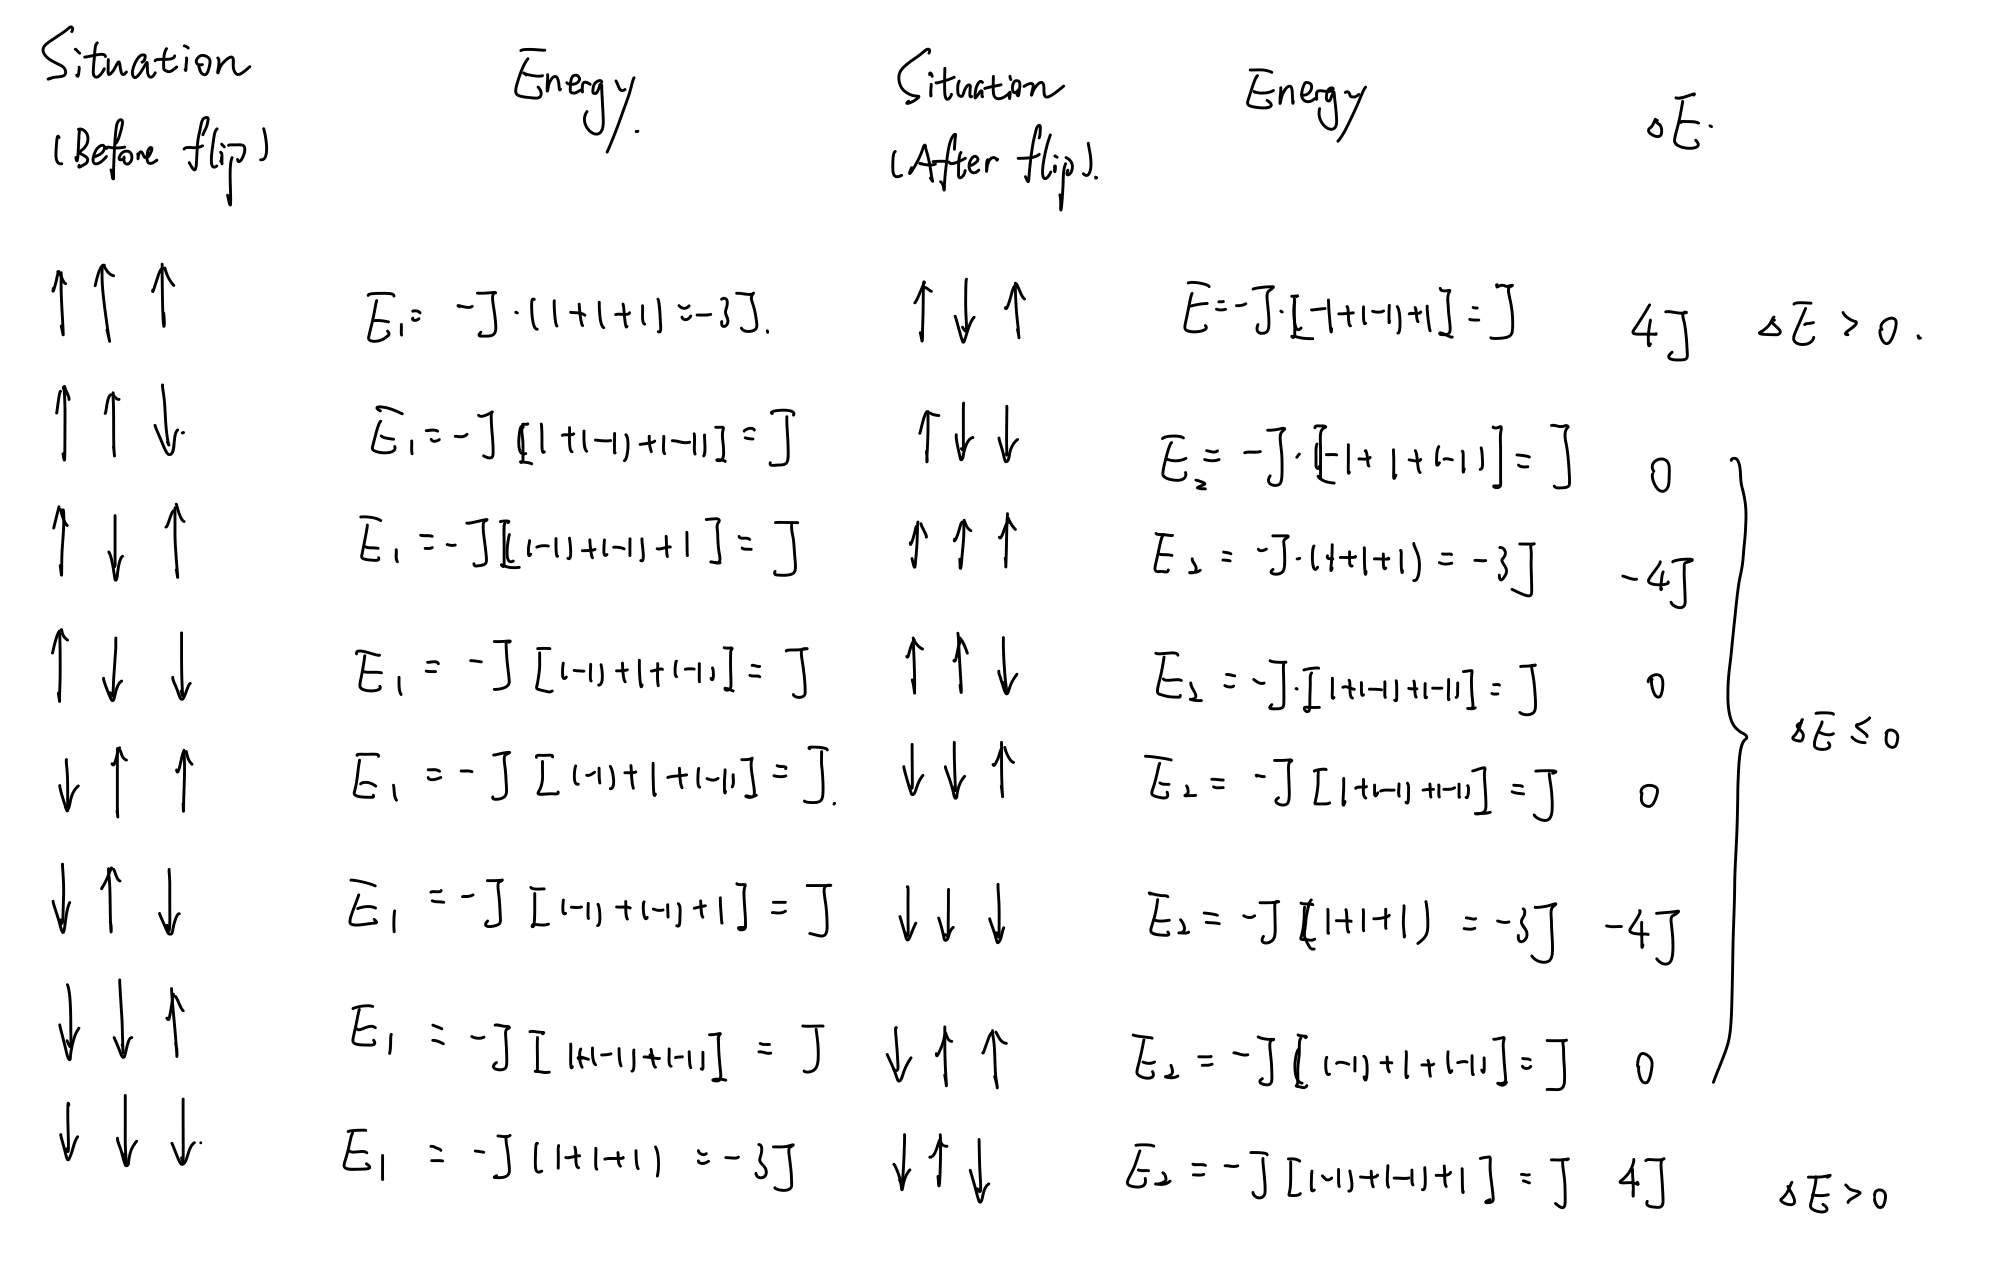

This gives us some clue to the final circuit design. The table shows that only in situation that all three spins are aligned in the same direction (either up or down), the energy change after the flip is positive, while the other situations all have energy changes smaller or equal to zero.

For the cirucit, we use two multiple control not gates to detect for aligned situation. If the three spins are in the same direciton, one of the gate will flip the scratch qubit. After these two gates, if the scratch qubit is 0 as it is initialized, we just flip the spins, the process of which is done with a CNOT gate whose control qubit needs to be 0. If the scratch qubit is 1, it means that the energy change after the spin is flipped is positive, making the flip a even with possibility P. Flipping the qubit with a possibility P is done by a CCNOT gate. The P, in context of ising model, is $P = e^{-\frac{\Delta E}{kT}}$, where *k* is a constant and $T$ is the temperature. For simplicity, we assume both $k$ and $T$ to be 1.

The probability qubit P can be initialized with a U gate. The process follows: \
The qubit is initialized as 0, which has a vector form
$
\begin{pmatrix}
1 \\
0
\end{pmatrix}
$
and the U gate in general form
$
\begin{pmatrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda}\cos(\frac{\theta}{2})
\end{pmatrix}
$
By performing matrix multiplication, we can get the general form of a vector:

$$
|\psi\rangle
=
\begin{pmatrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\
e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\phi+\lambda}\cos(\frac{\theta}{2})
\end{pmatrix}
\begin{pmatrix}
1 \\
0
\end{pmatrix}
=
\begin{pmatrix}
\cos(\frac{\theta}{2})\\
e^{i\phi}\sin(\frac{\theta}{2})
\end{pmatrix}
$$
Remember the CCNOT gate associated with possibility flip is a CCNOT gate which will only flip if all the control qubit is 1. If we want the spin to be flipped with a possibility P, we need the qubit to be measured as 1 with possibility P, and therefore possibilty amplitude $\sqrt{P}$, meaning that:
$$
\begin{pmatrix}
\cos(\frac{\theta}{2})\\
e^{i\phi}\sin(\frac{\theta}{2})
\end{pmatrix}
=
\begin{pmatrix}
\sqrt{1-P} \\
\sqrt{P}
\end{pmatrix}
$$
The equation gives us that
$$
\theta = 2\arccos(\sqrt{1-P})
$$
while $\phi$ and $\lambda$ can be any numbers. As a result, we need a U gate that looks like this $U(2\arccos(\sqrt{1-P}), 0, 0)$

The whole circuit is:

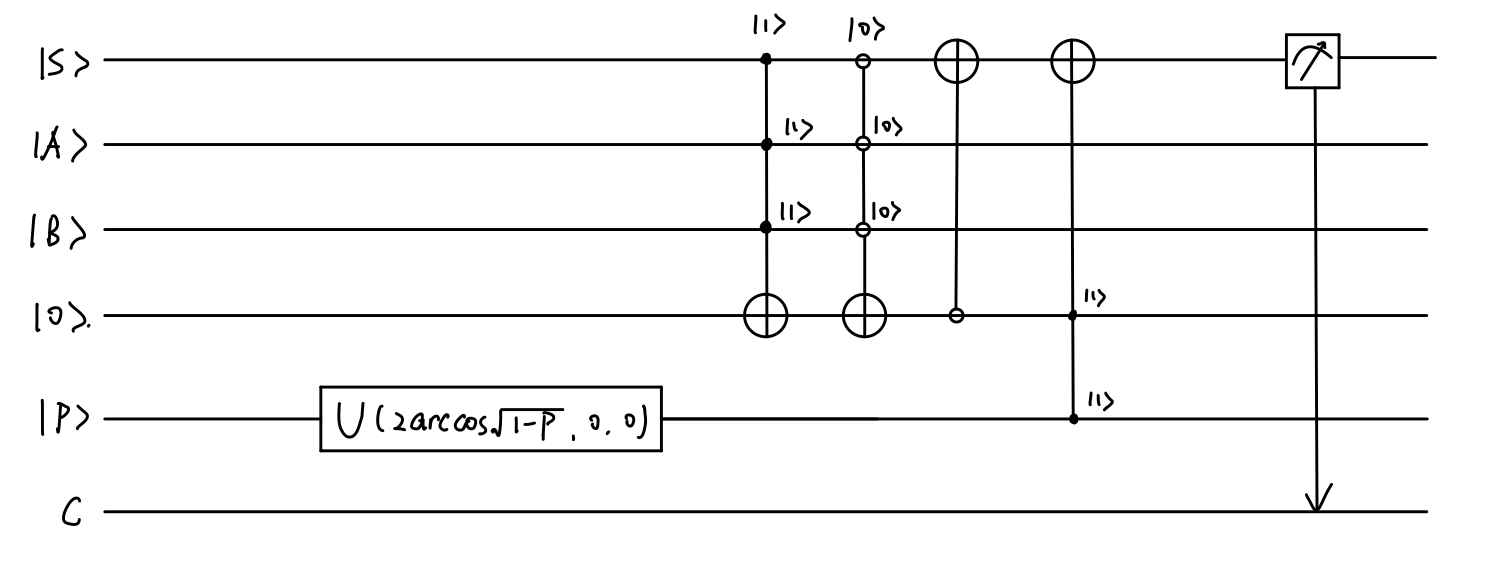

**Notice: circuit is only designed for one flip. You need a loop to go through all the spins in the system.**

Below is the Python Implementation:

In [181]:
# Define functions for Ising interaction
def isingAlgorithm(index):
        
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P)), 0, 0, q[4])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[3]) 

    for temp4 in range(3):
        qc.x(q[temp4])
    qc.mcx([q[0], q[1], q[2]], q[3])
    for temp5 in range(3):
        qc.x(q[temp5])

    qc.x(q[3])
    qc.cx(q[3], q[0])
    qc.x(q[3])

    qc.ccx(q[4], q[3], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

28.339496612548828 seconds
{'[1, 1, 1, -1]': 6, '[1, -1, -1, -1]': 22, '[-1, -1, -1, -1]': 59, '[1, 1, 1, 1]': 5, '[1, 1, -1, -1]': 8}


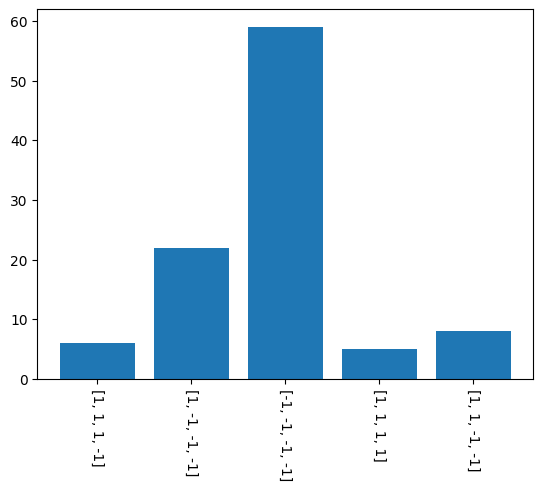

In [182]:
start = time()

dyct = {}

# Set Parameters
J = -0.25*np.log(0.5) # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)

# Set the numbers of trials
trialnumbers = 100

# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, 1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range (0, len(spins)):
        isingAlgorithm(branchloop)

    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plotdyct(dyct)

In [179]:
# Define functions for Ising interaction
def isingupAlgorithm(index):
        
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(P)), 0, 0, q[4])
            
    if spins[index - 1] == 1:
        qc.x(q[0])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.ccx(q[0], q[2], q[3]) 

    # Operation 2
    qc.ccx(q[3], q[4], q[1])

    # Operation 3
    qc.measure(q[1], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return int(list(counts.keys())[0])

def isingdownAlgorithm(index):
        
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(P)), 0, 0, q[4])
            
    if spins[index - 1] == 1:
        qc.x(q[0])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[0])
    qc.x(q[2])
    qc.ccx(q[0], q[2], q[3])
    qc.x(q[0])
    qc.x(q[2])

    # Operation 2
    qc.ccx(q[3], q[4], q[1])

    # Operation 3
    qc.measure(q[1], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return int(list(counts.keys())[0])

28.48433780670166 seconds
{'[1, 1, -1, -1]': 9, '[1, -1, -1, -1]': 23, '[-1, -1, -1, -1]': 55, '[1, 1, 1, 1]': 4, '[1, 1, 1, -1]': 9}


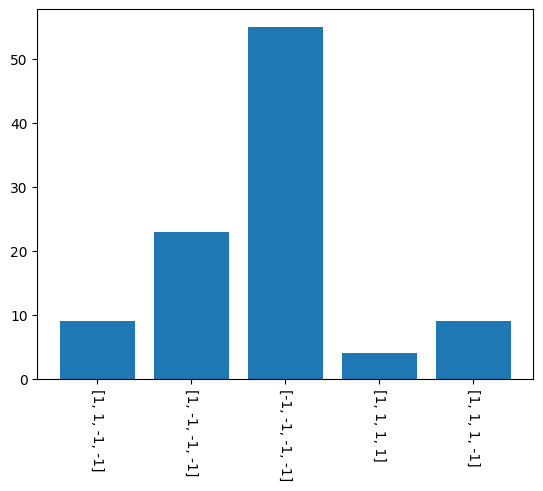

In [180]:
start = time()

dyct = {}

# Set Parameters
J = -0.25*np.log(0.5) # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P = np.exp(-4 * J / T)

# Set the numbers of trials
trialnumbers = 100

# Initialize the circuit
q = QuantumRegister(5)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = [1, 1, 1, 1]

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for branchloop in range (0, len(spins)):
        if spins[branchloop] > 0:
            spins[branchloop] = spins[branchloop] * (2 * isingupAlgorithm(branchloop) - 1) * spins[branchloop]
        else:
            spins[branchloop] = spins[branchloop] * (-2 * isingdownAlgorithm(branchloop) + 1) * spins[branchloop]

    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plotdyct(dyct)

## 1D Ising Model (With External Magnetic Field)

From the prove above, we can learn that no matter how many spins there are, for a single flip action, we only need to consider the spin itself and its two neighbors. We can list all of the situations.

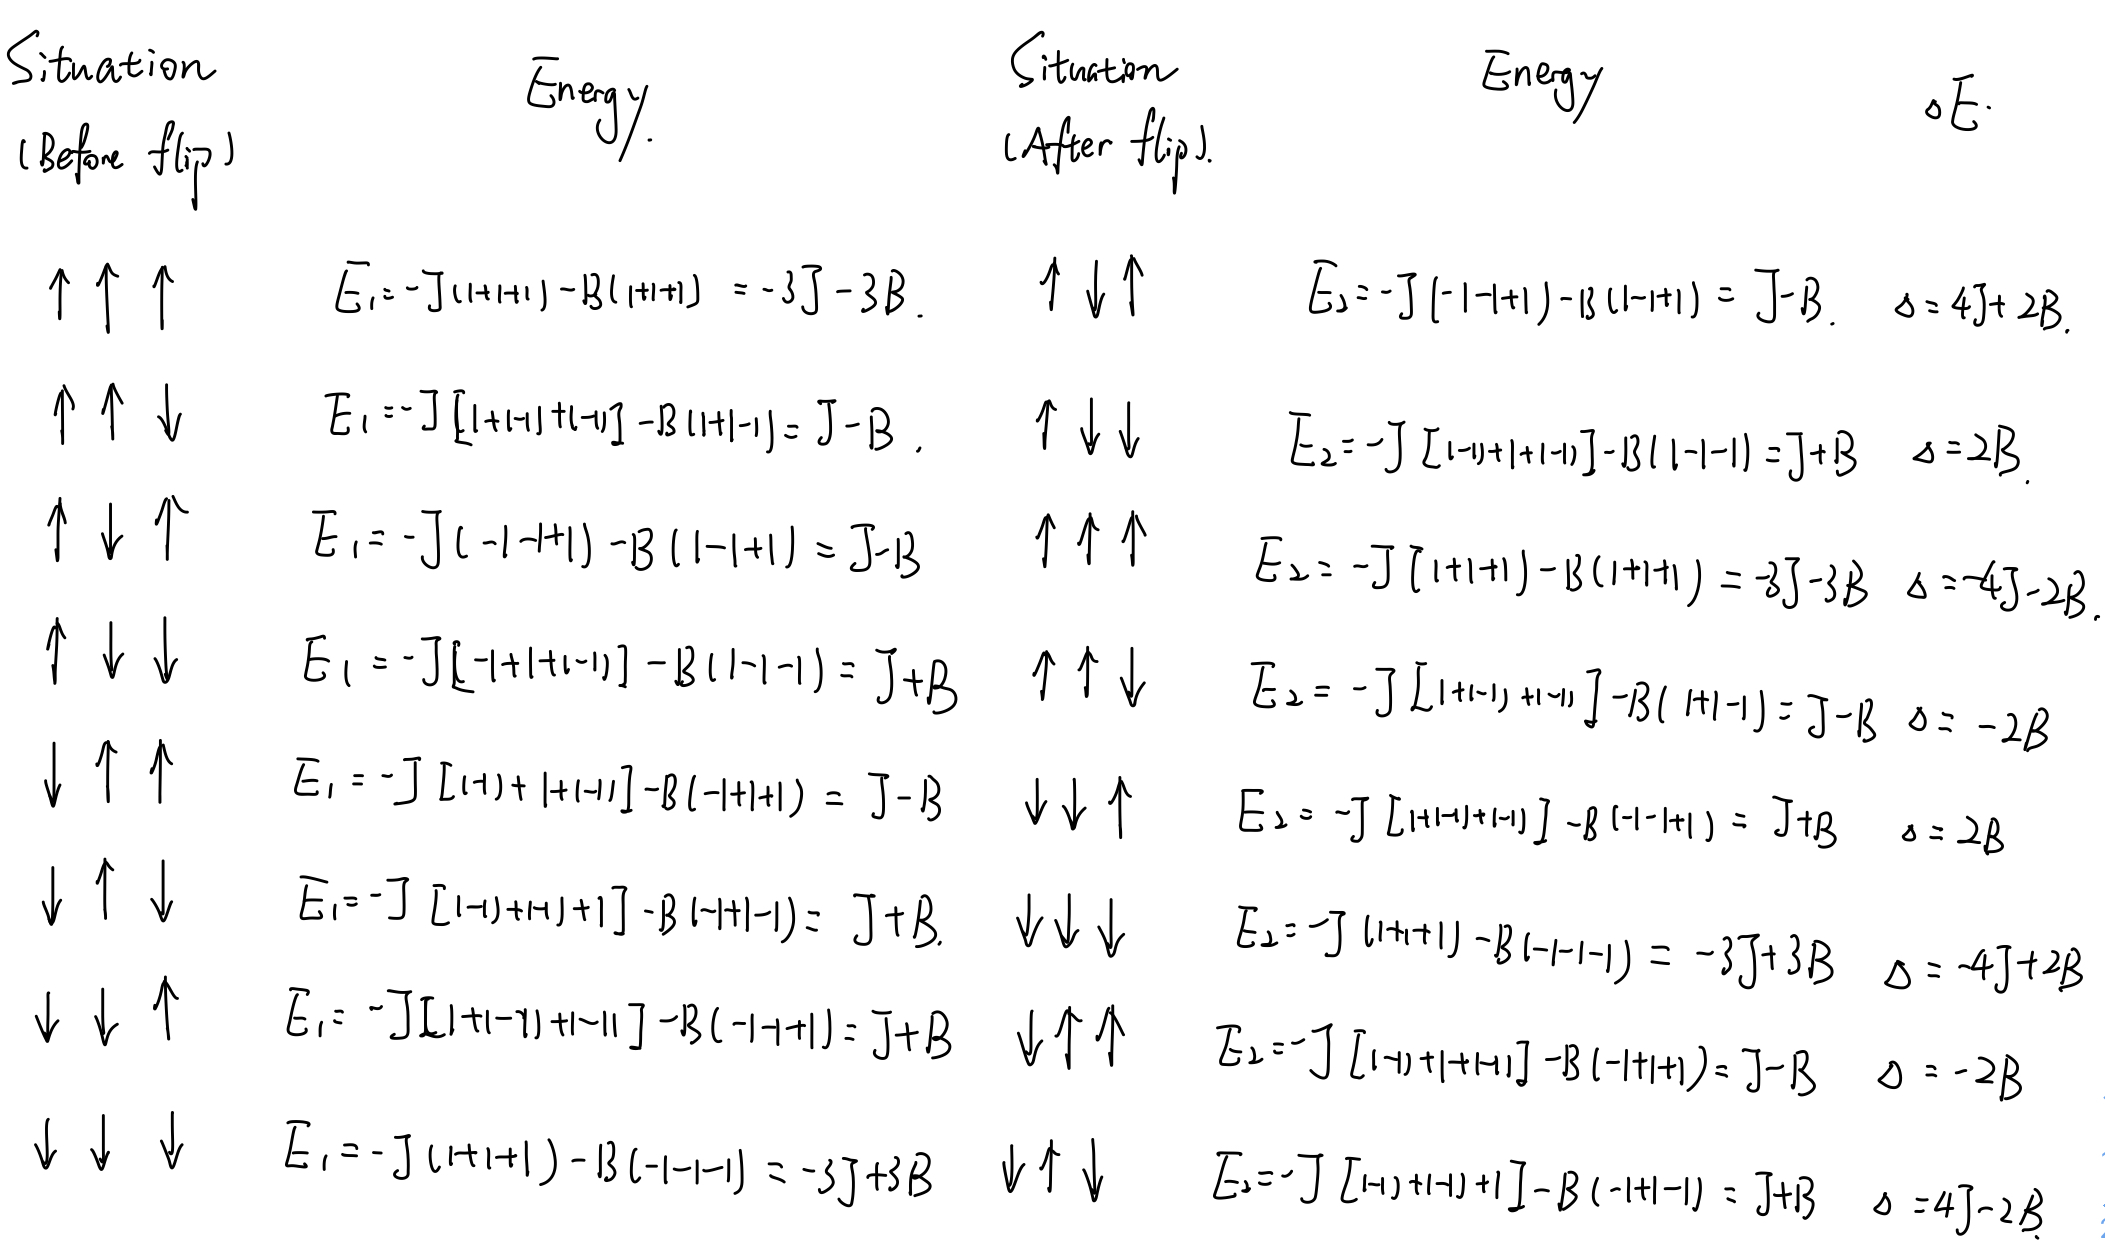

As shown in the picture, there are 8 situations in total. The 8 situation can be reorganized into another 6 situations regarding the energy change after a flip, expressed in the relationship between B and J.

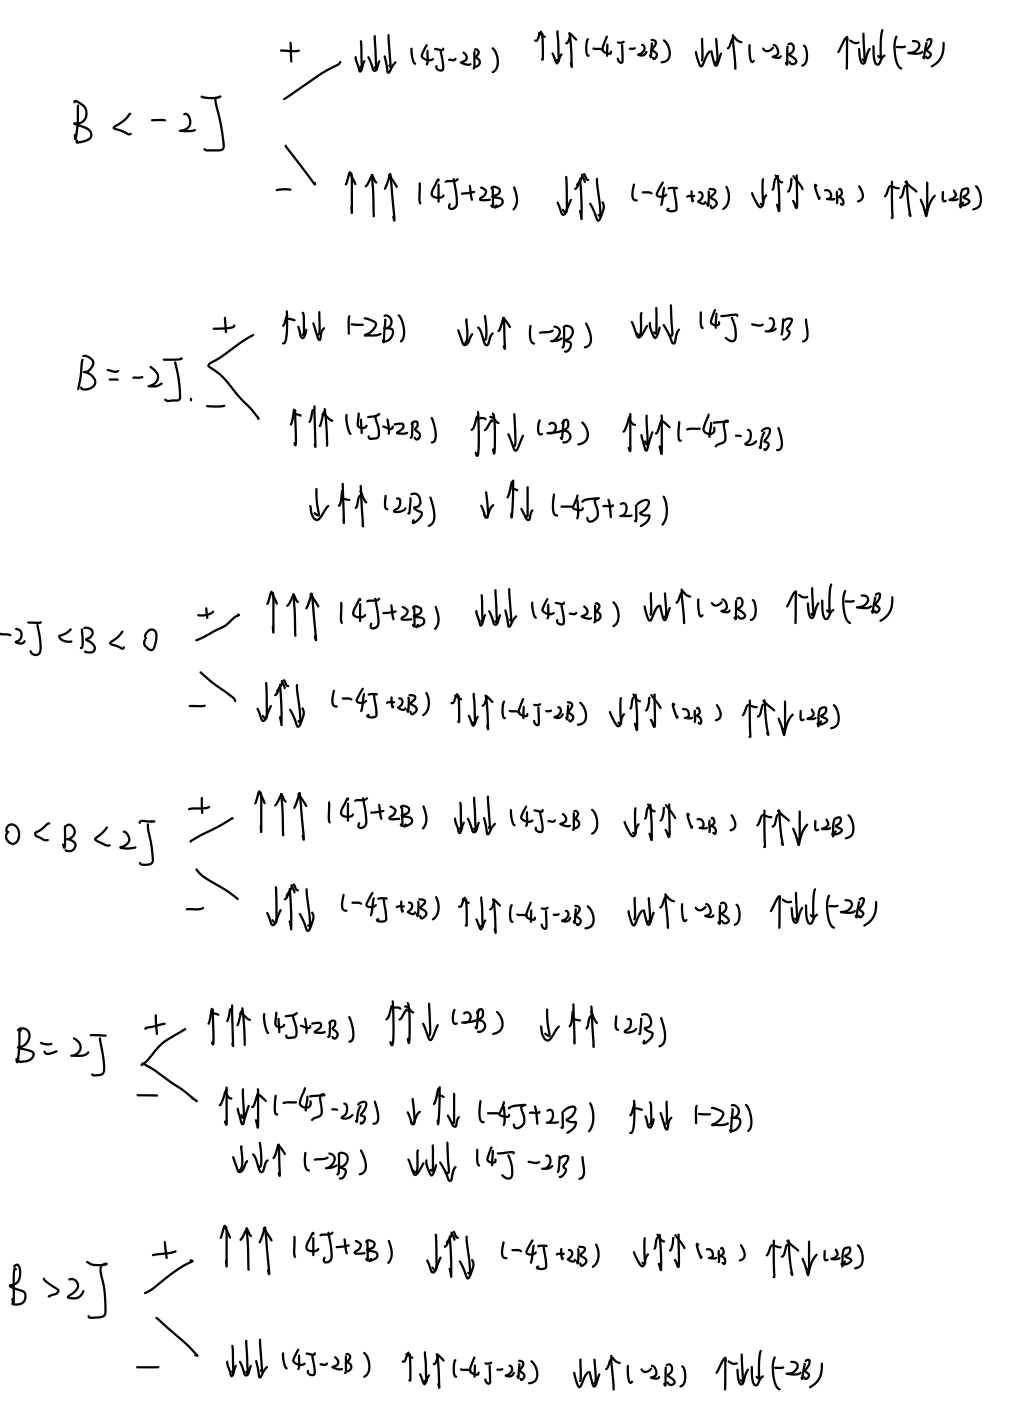

In the diagram above, a positive sign indicates the energy change of the system will be positive after a flip under the specific circumstance, while a negative sign indicates that the energy change of the system will be either negative or zero. The expression in the bracket shows the energy change. The circuits for these situations are presented below.

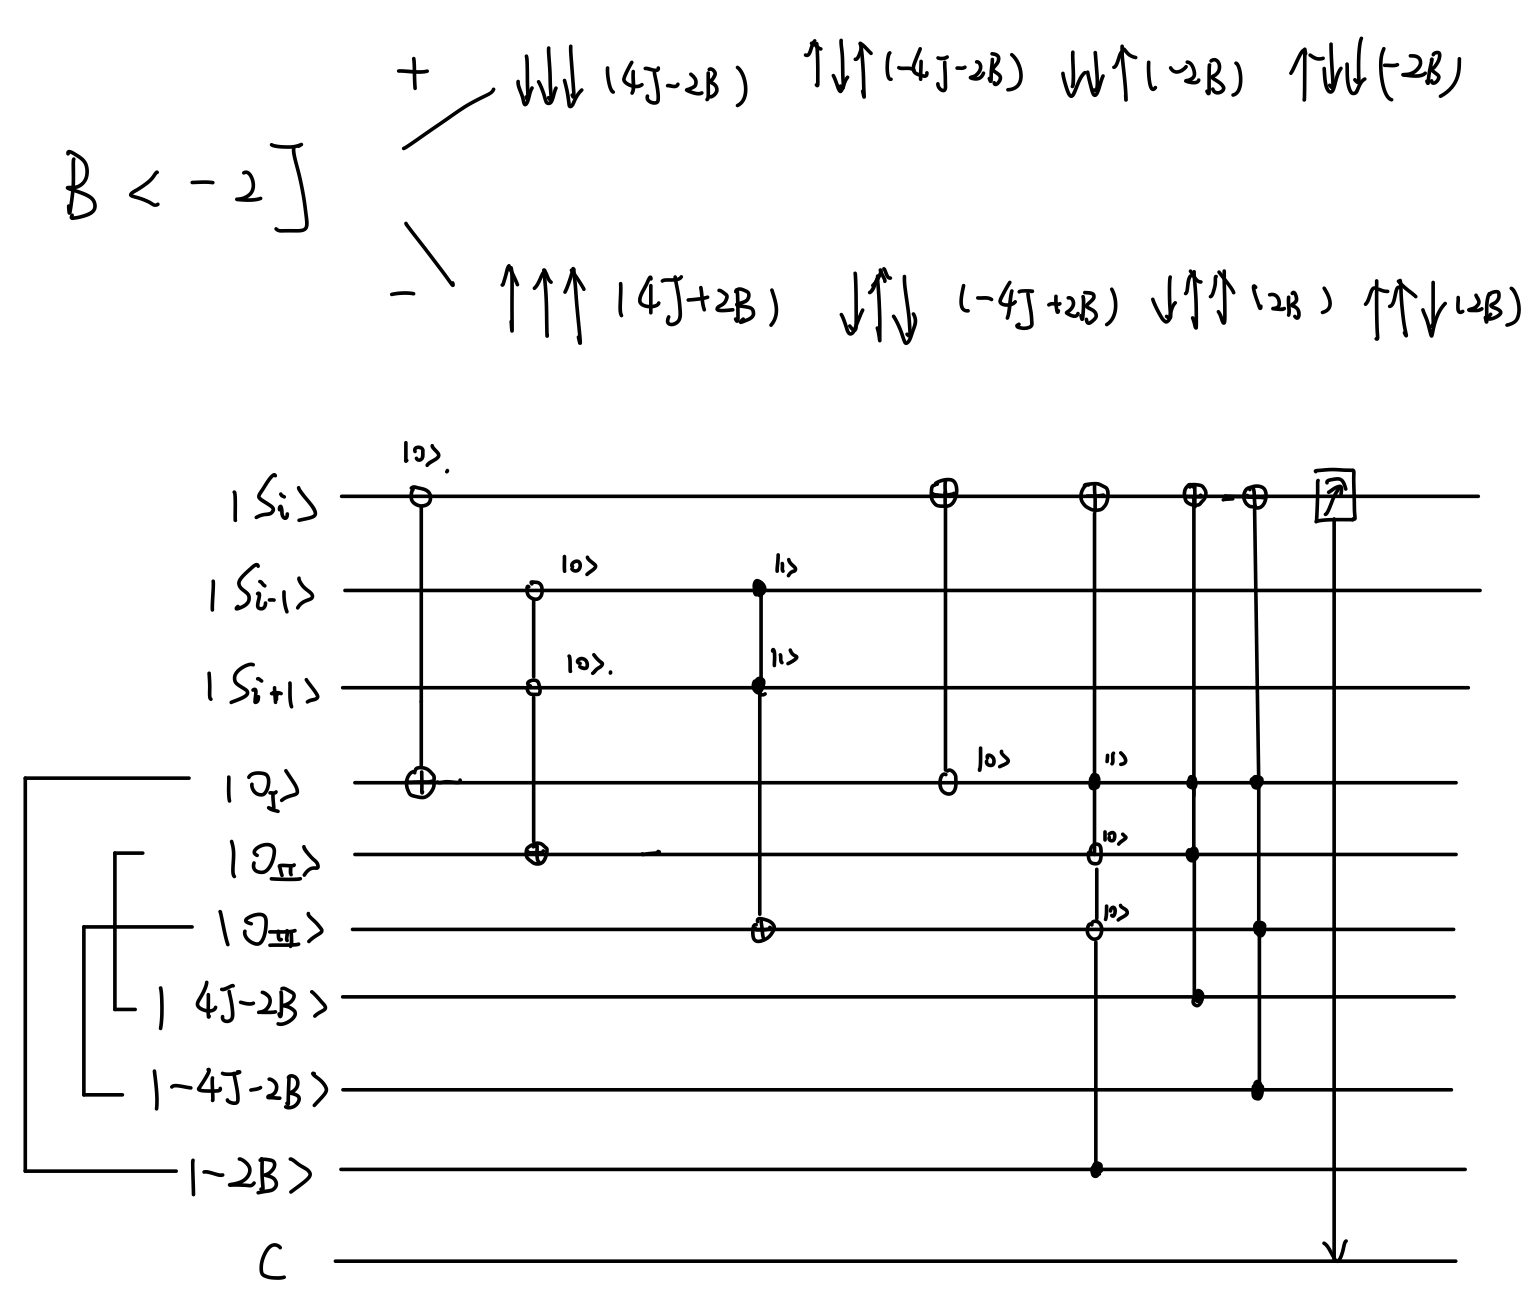

*Note: The line is only used to link correpsonding scrtch qubit and probability qubit. Same for below*

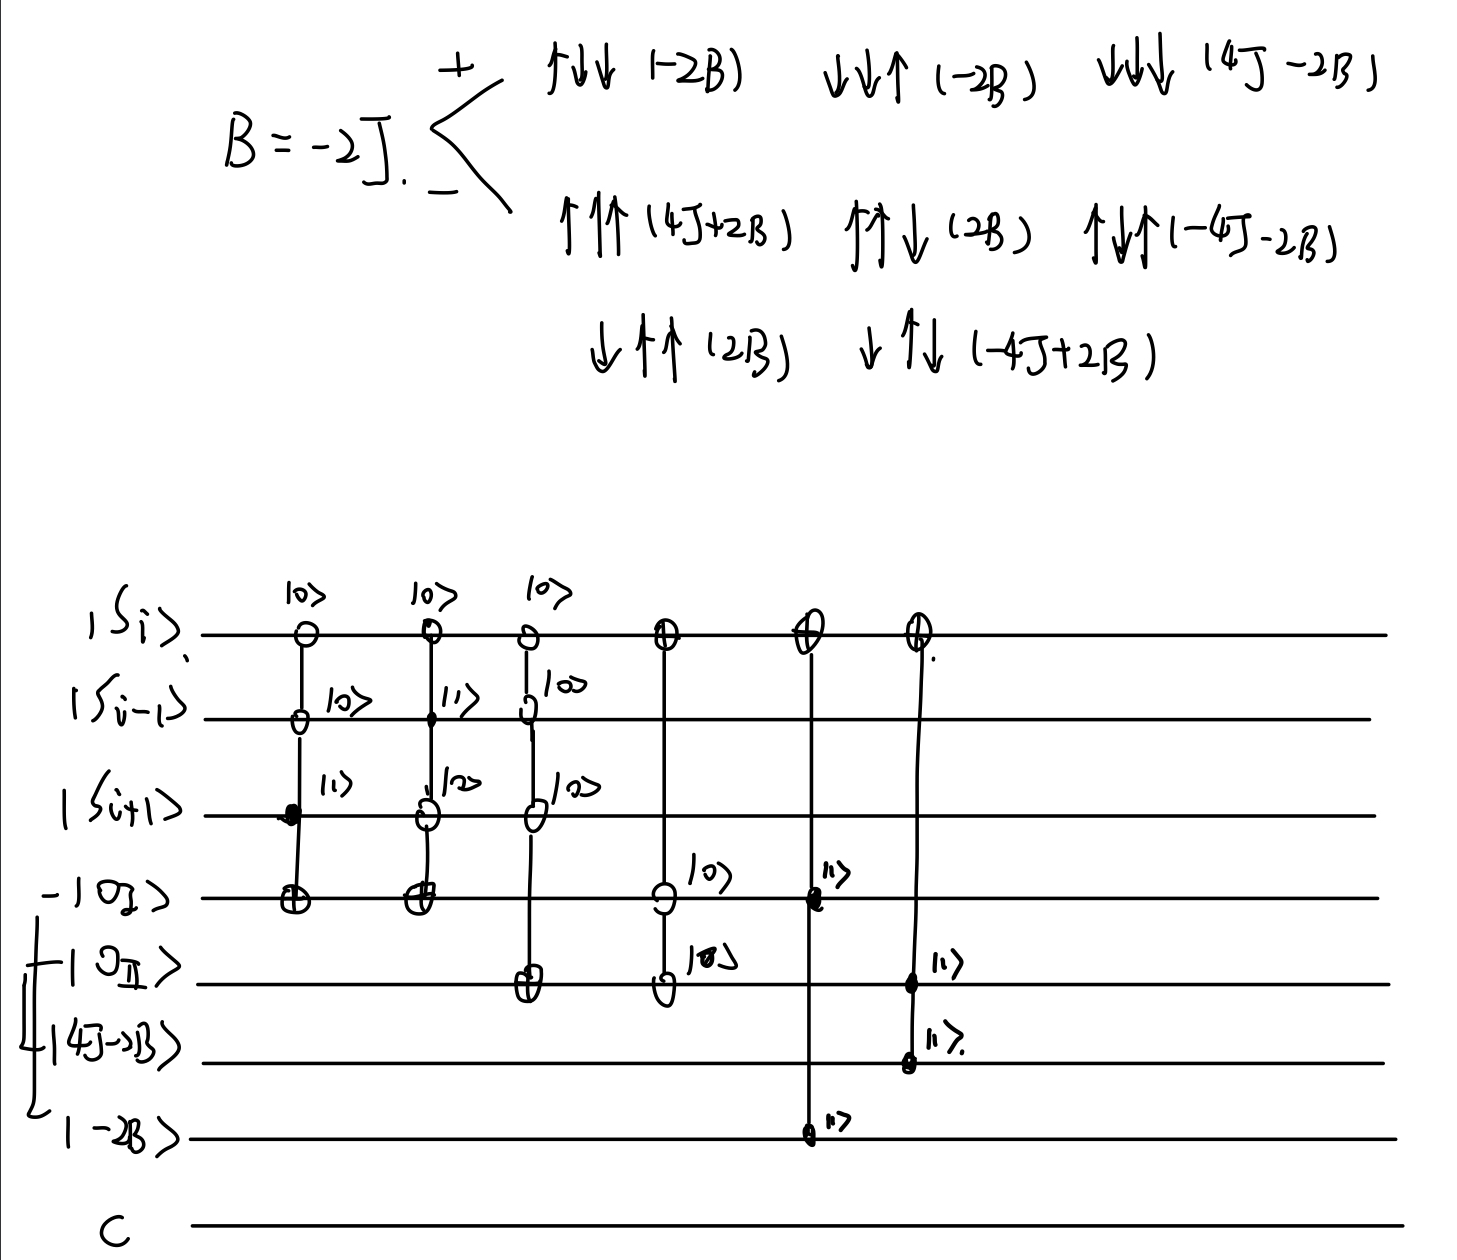

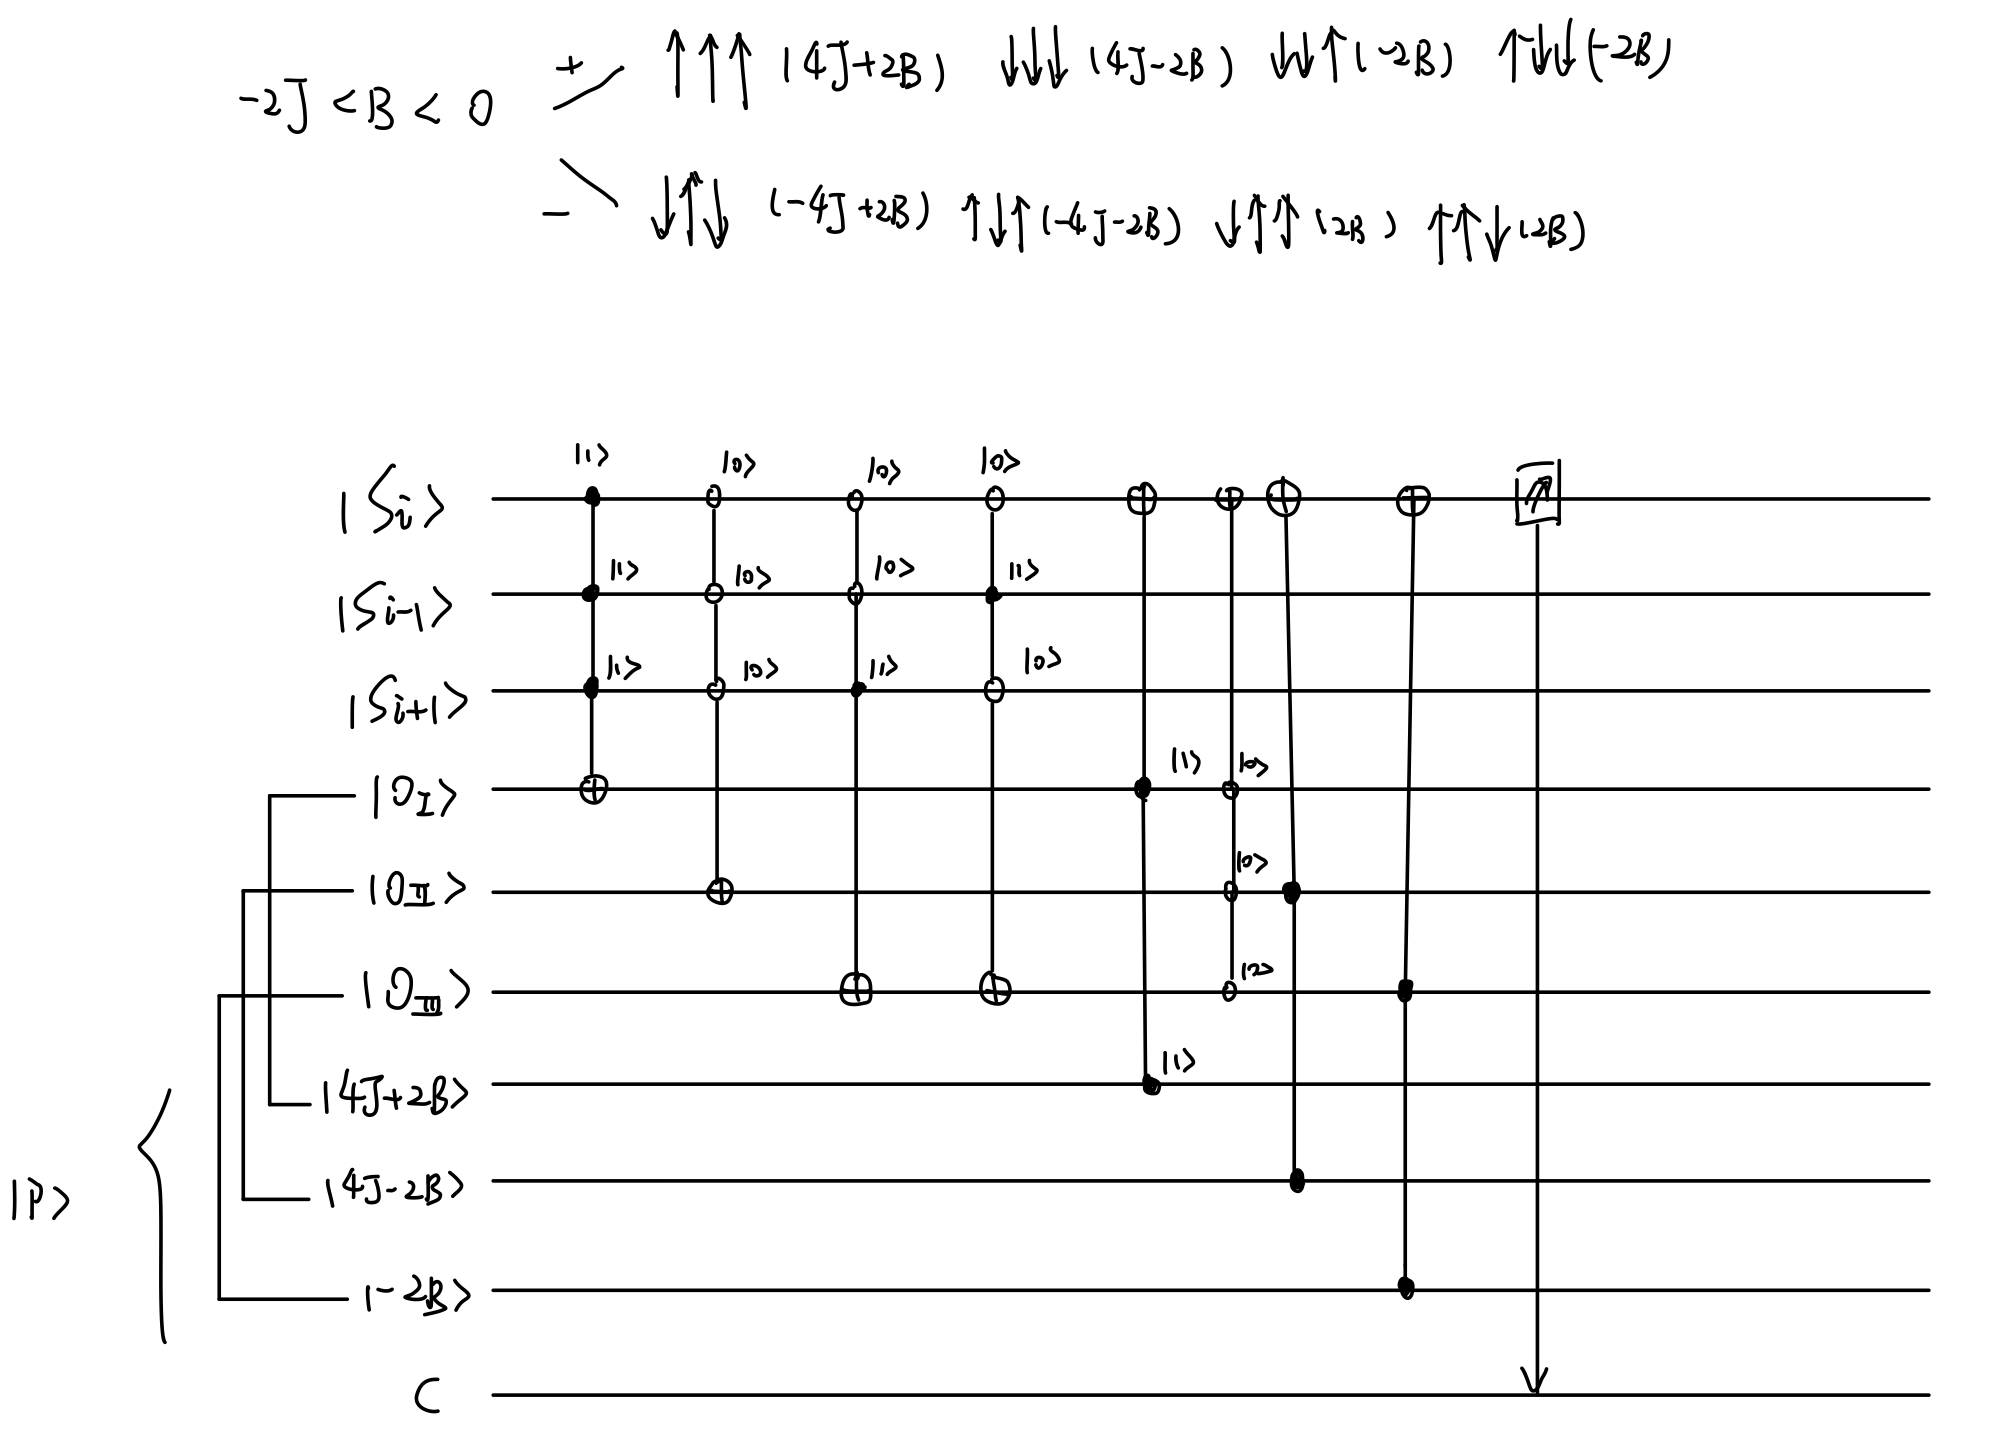

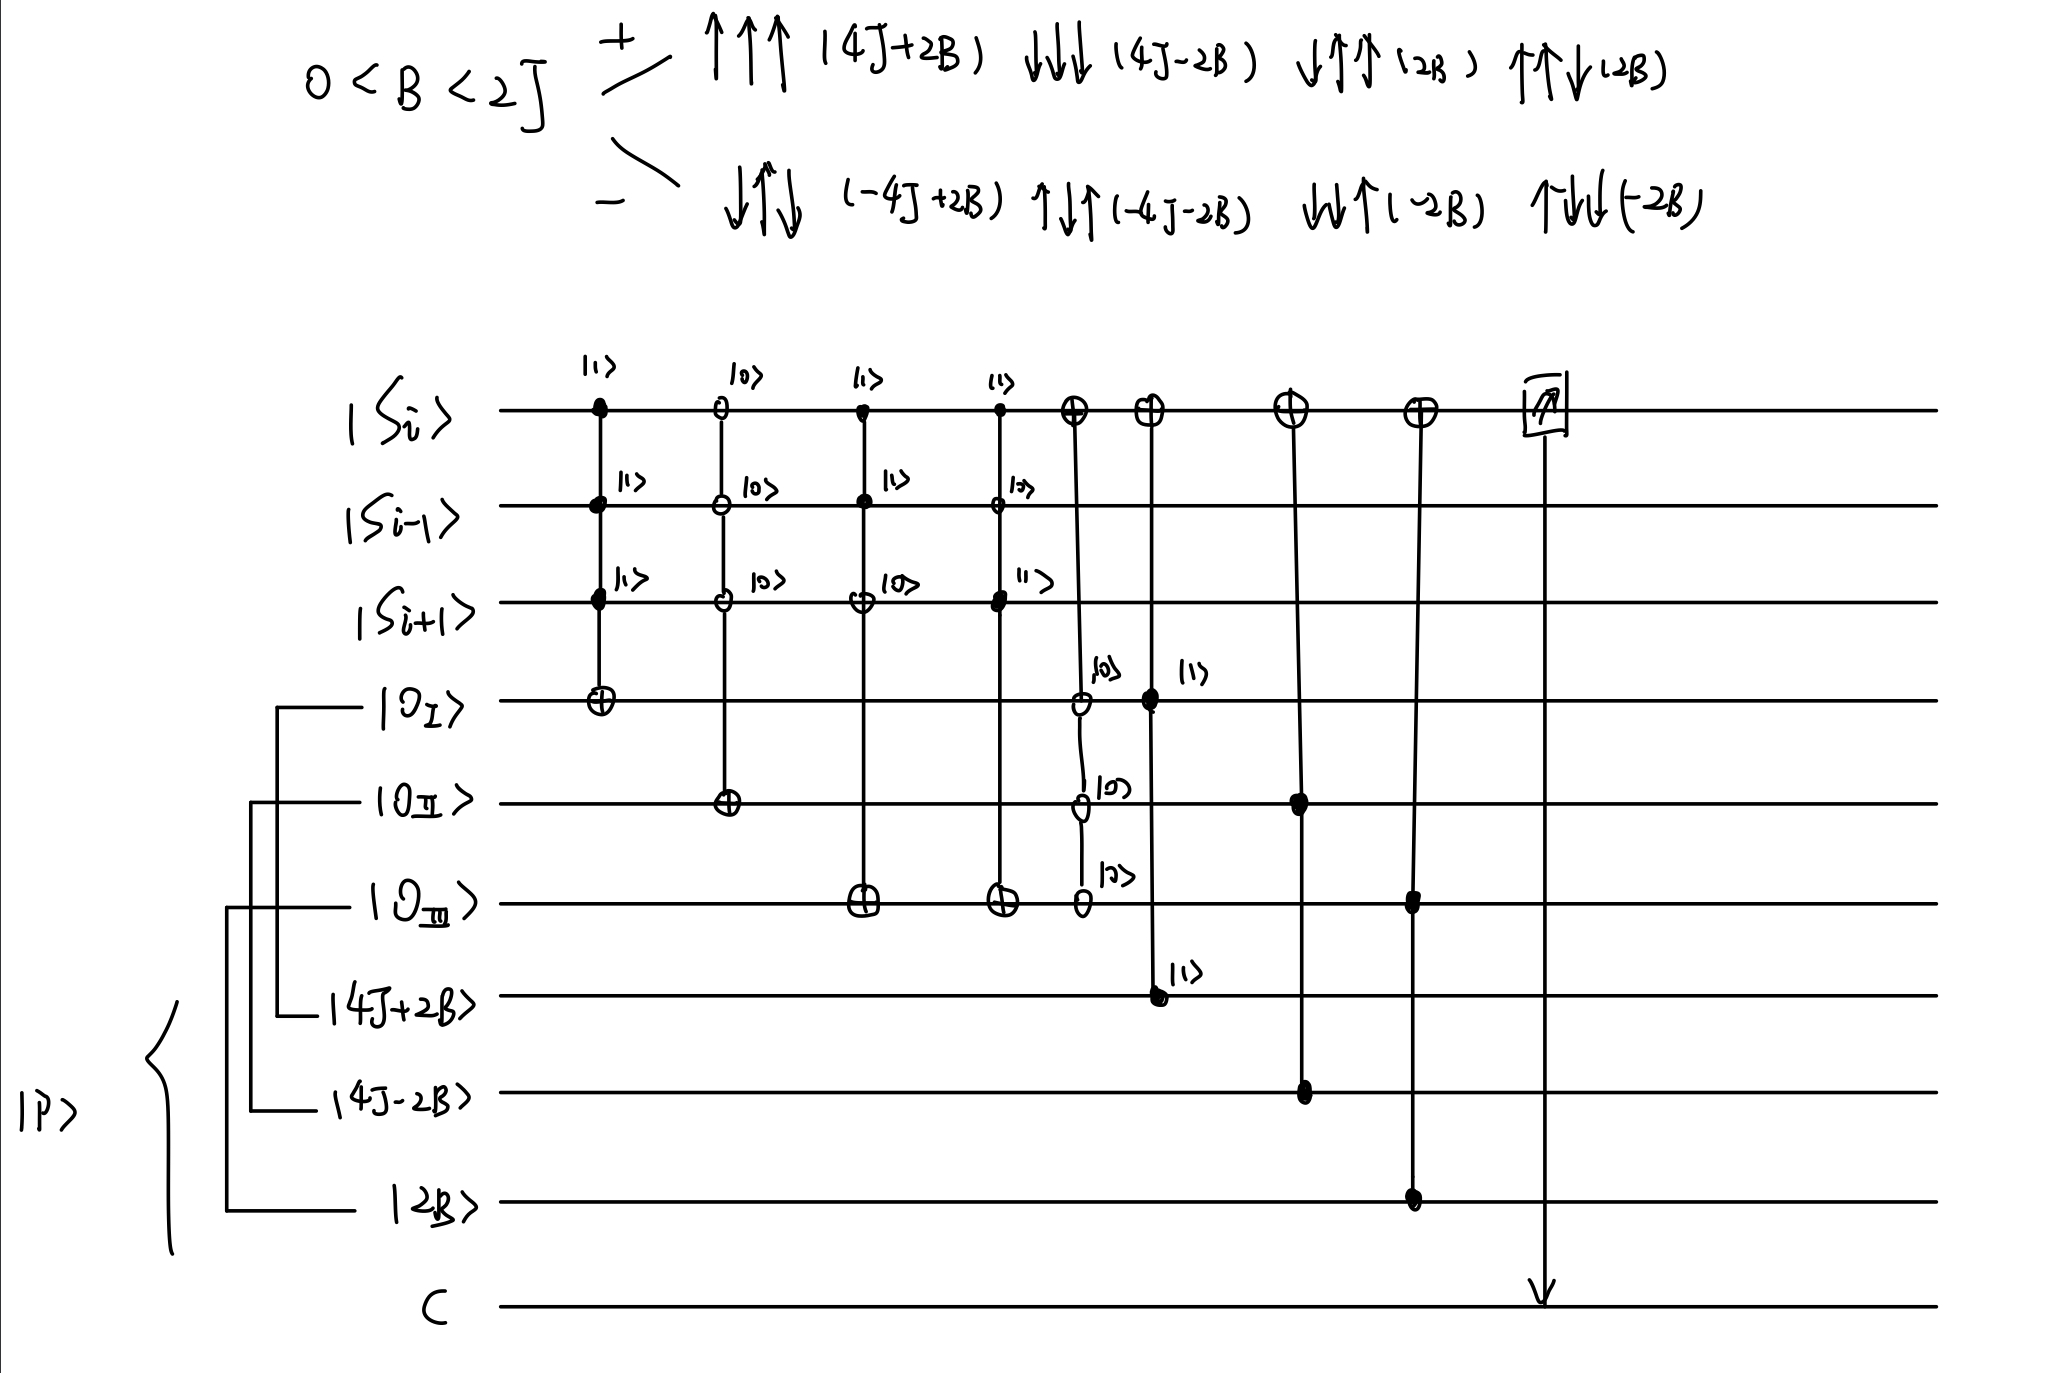

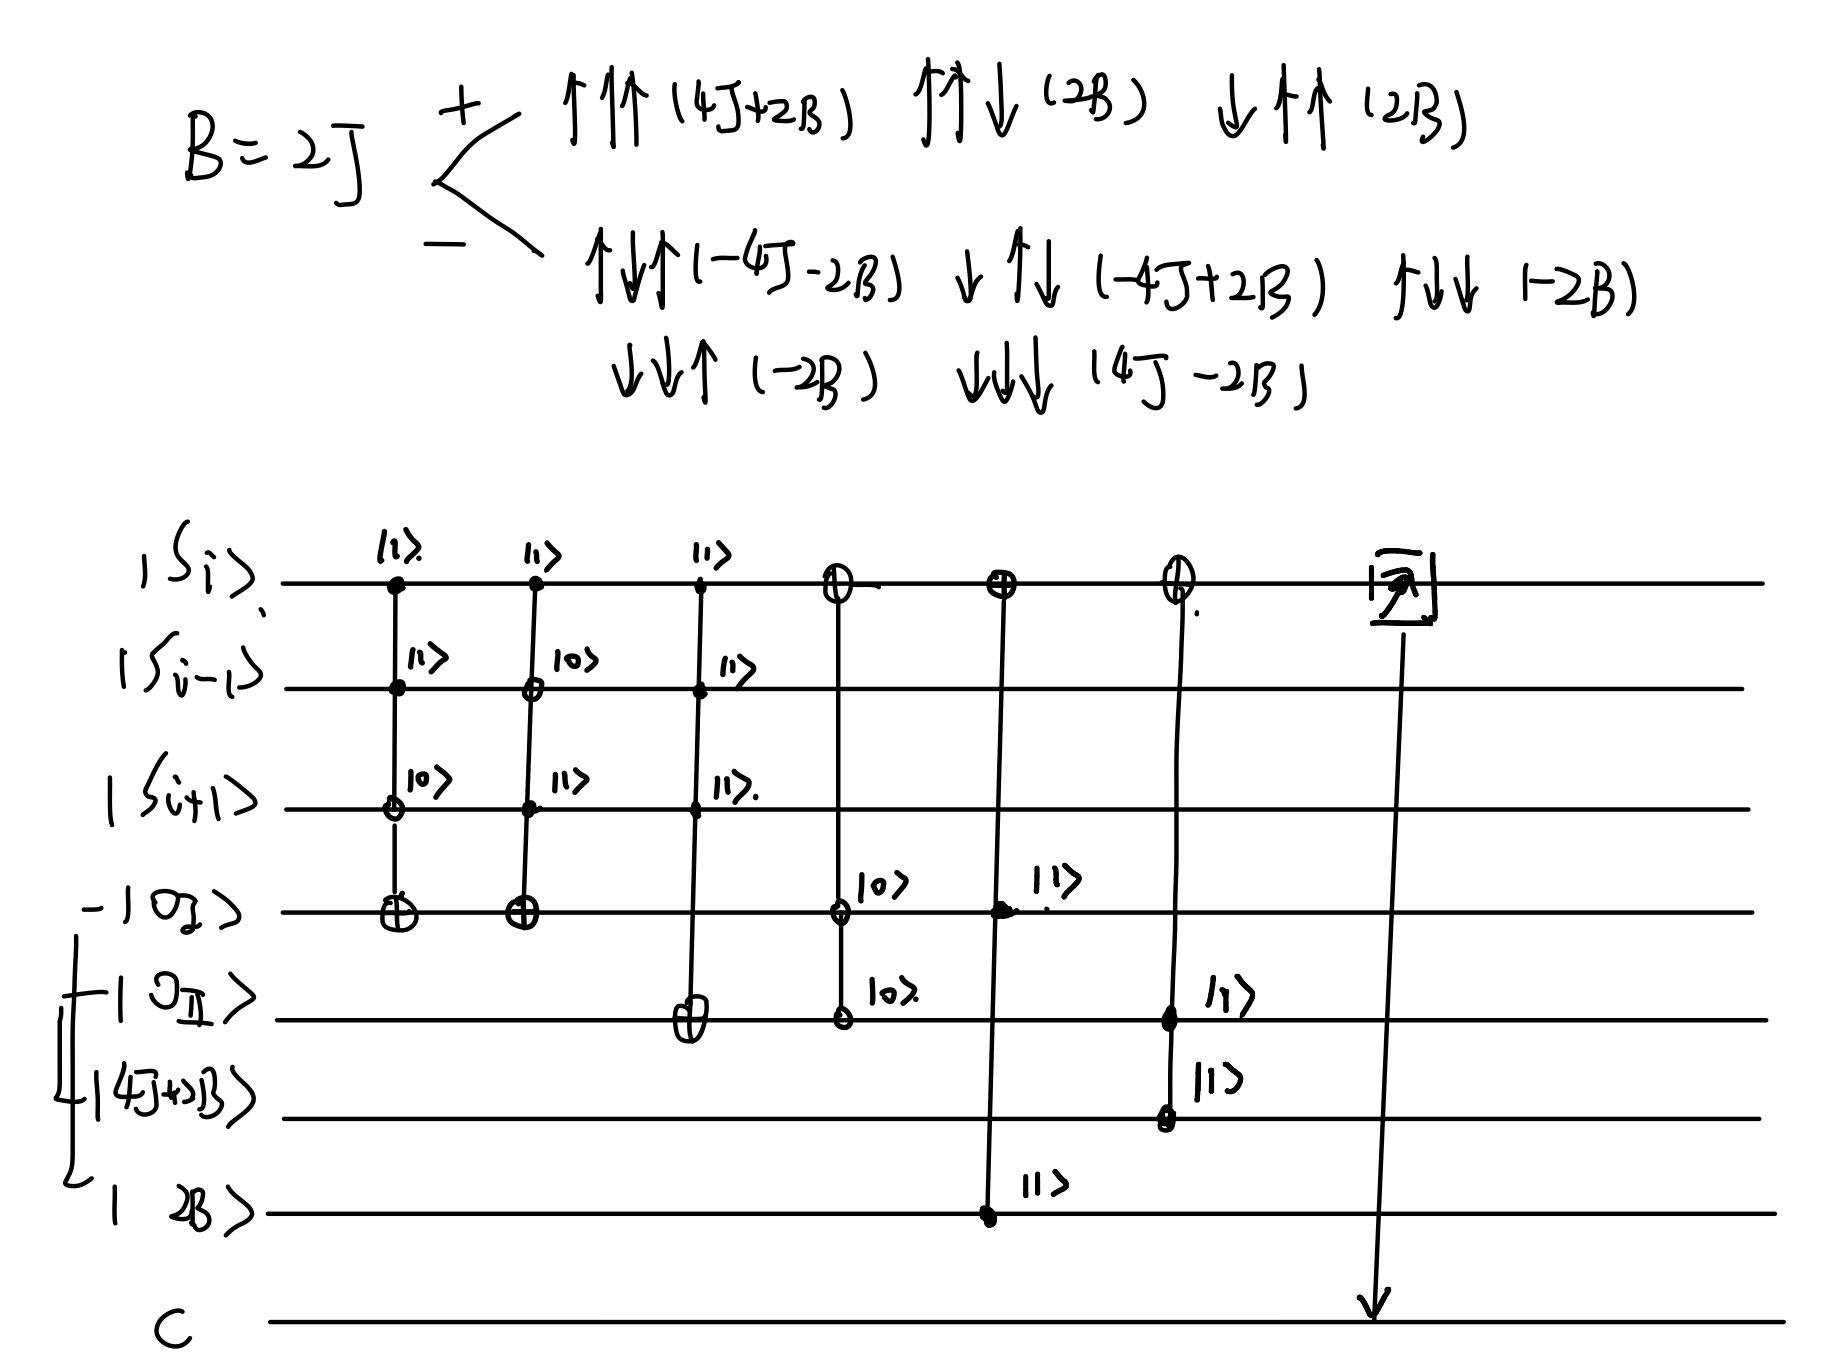

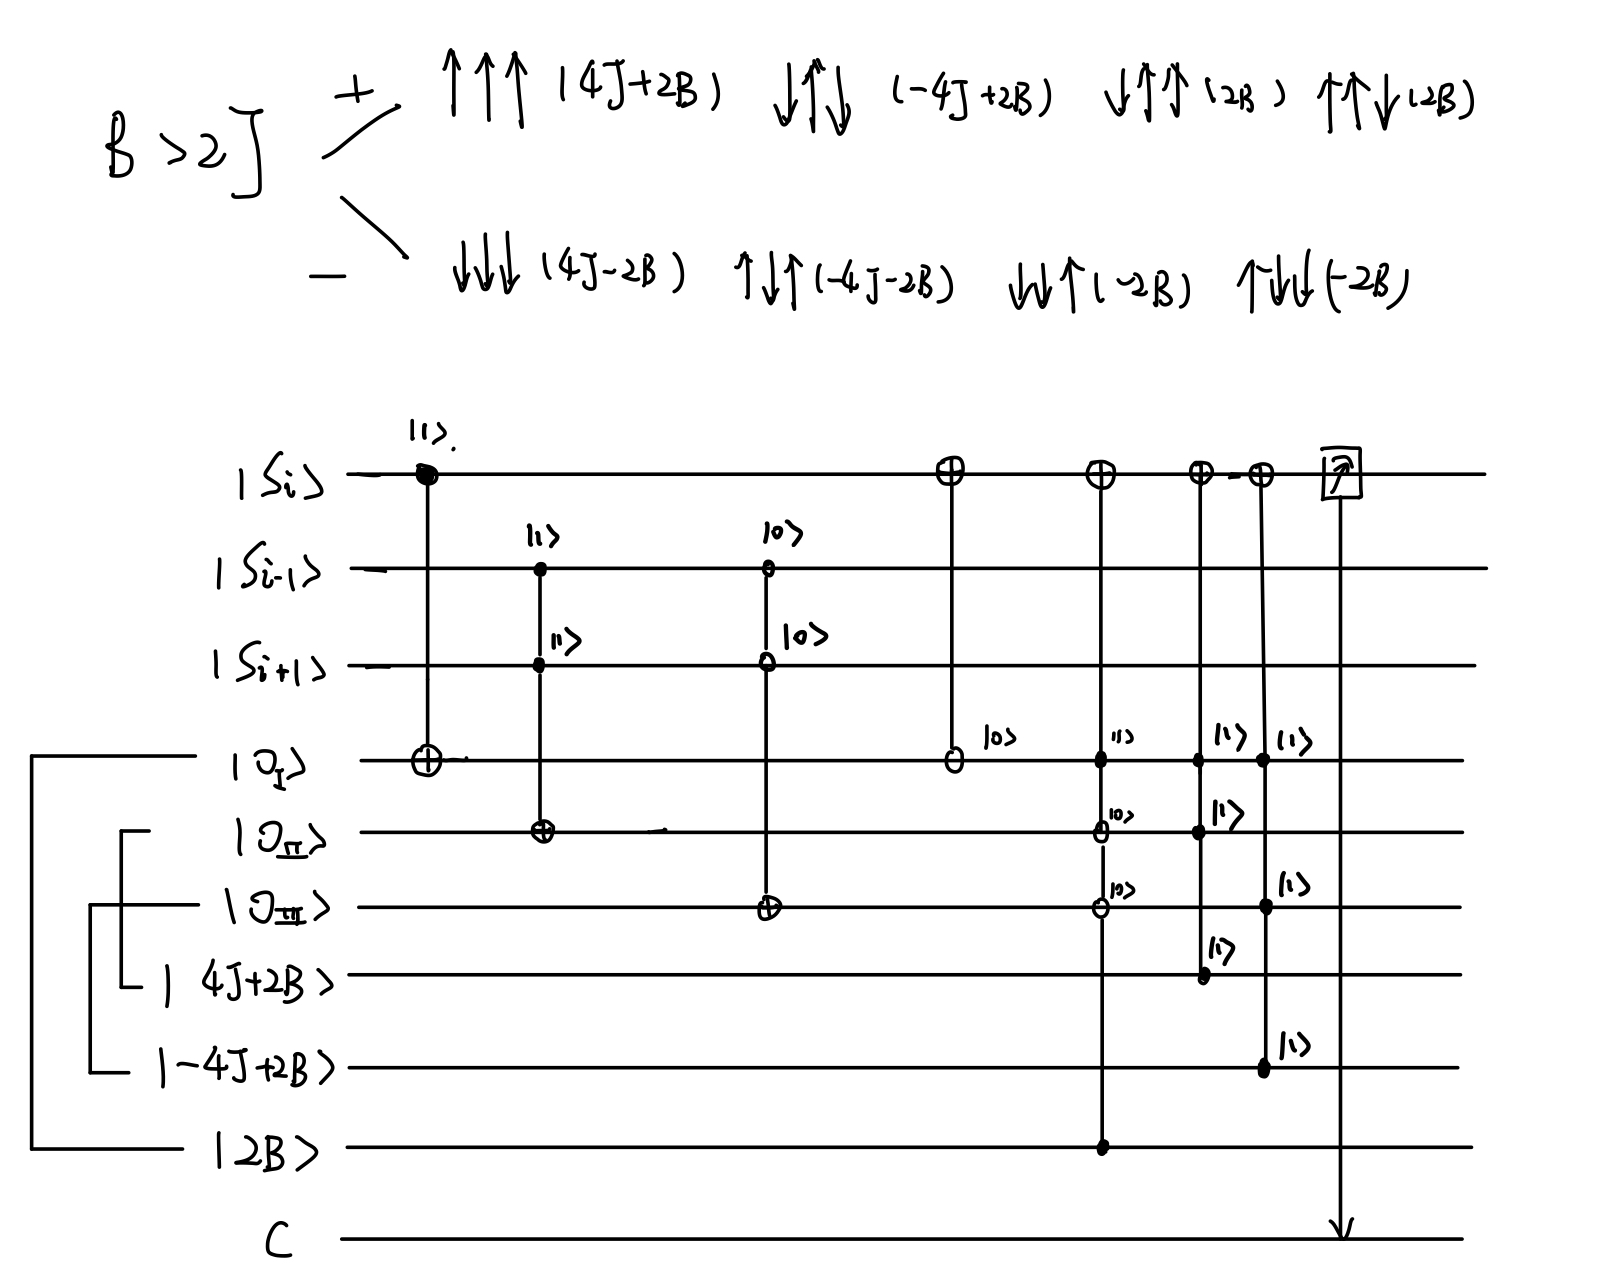

A line connected the scratch qubit 0 and a probability qubit is just for identification (showing every probability qubit is triggered by which scratch qubit). The codes implementation are below:

### Quantum (+ Classic) Algorithm

In [ ]:
# Ising interaction for magnitude of magnetic field B less than -2J
def iA_Bsmallern2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[0])
    qc.cx(q[0],q[3])
    qc.x(q[0])
    
    # Operation 2
    qc.x(q[1])
    qc.x(q[2])
    qc.ccx(q[1],q[2],q[4])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.ccx(q[1],q[2],q[5])
    
    # Operation 4
    qc.x(q[3])
    qc.cx(q[3],q[0])
    qc.x(q[3])
    
    # Operation 5
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3], q[4], q[5], q[8]], q[0])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.mcx([q[3], q[4], q[6]], q[0])
    
    # Operation 7
    qc.mcx([q[3], q[5], q[7]], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B equal to -2J
def iA_Bequaln2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[5])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[6])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[0])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[0])
    qc.x(q[2])
    
    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 3
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[3])
    qc.x(q[4])
    qc.ccx(q[3],q[4], q[0])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.ccx(q[3],q[5], q[0])
    
    # Operation 6
    qc.ccx(q[4],q[6], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B larger than -2J but smaller than 0
def iA_Blargern2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])
    
    # Operation 1
    qc.mcx([q[0],q[1],q[2]], q[3])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[0])
    qc.x(q[2])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3],q[4],q[5]], q[0])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.ccx(q[3],q[6], q[0])
    
    # Operation 7
    qc.ccx(q[4],q[7], q[0])
    
    # Operation 8
    qc.ccx(q[5],q[8], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B larger than 0 but smaller than 2J
def iA_Bsmallerp2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])
    
    # Operation 1
    qc.mcx([q[0],q[1],q[2]], q[3])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[5])
    qc.x(q[1])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3],q[4],q[5]], q[0])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.ccx(q[3],q[6], q[0])
    
    # Operation 7
    qc.ccx(q[4],q[7], q[0])
    
    # Operation 8
    qc.ccx(q[5],q[8], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B equal to 2J
def iA_Bequalp2J(index):
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[5])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[6])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[2])
    
    # Operation 2
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2]], q[3])
    qc.x(q[1])
    
    # Operation 3
    qc.mcx([q[0],q[1],q[2]], q[4])
    
    # Operation 4
    qc.x(q[3])
    qc.x(q[4])
    qc.ccx(q[3],q[4], q[0])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.ccx(q[3],q[5], q[0])
    
    # Operation 6
    qc.ccx(q[4],q[6], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

# Ising interaction for magnitude of magnetic field B larger than 2J
def iA_Blargerp2J(index):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[6])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(1 - P3)), 0, 0, q[8])

    if spins[index] == 1:
        qc.x(q[0])
            
    if spins[index - 1] == 1:
        qc.x(q[1])

    if spins[(index + 1) % len(spins)] == 1:
        qc.x(q[2])

    # Operation 1
    qc.cx(q[0],q[3])
    
    # Operation 2
    qc.ccx(q[1],q[2],q[4])
    
    # Operation 3
    qc.x(q[1])
    qc.x(q[2])
    qc.ccx(q[1],q[2],q[5])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[3])
    qc.cx(q[3],q[0])
    qc.x(q[3])
    
    # Operation 5
    qc.x(q[4])
    qc.x(q[5])
    qc.mcx([q[3], q[4], q[5], q[8]], q[0])
    qc.x(q[4])
    qc.x(q[5])
    
    # Operation 6
    qc.mcx([q[3], q[4], q[6]], q[0])
    
    # Operation 7
    qc.mcx([q[3], q[5], q[7]], q[0])

    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1024
    results = execute(qc, backend, shots=shots).result()
    counts = results.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[index] = 1
    elif newstat == 0:
        spins[index] = -1

Below is a test program

In [ ]:
start = time()
dyct = {}

# Set Parameters
# Parameters are set so that the possibility of each flip is 0.5
J = -0.25 * np.log(0.5) # Coupling Strength
T = 1 # Temperature
B = -0.5 * np.log(0.5) # Magnitude of Magnetic field

# Set Trial Numbers
trialnumbers = 1000

# Initialized Spins
inispins = [-1, 1, 1, -1]

if B == np.abs(2 * J):
    q = QuantumRegister(7)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    if B == (-2 * J):
        P1 = np.exp(-((-2 * B)/ T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bequaln2J(branchloop)
            encode(dyct, spins)
    
    elif B == (2 * J):
        P1 = np.exp(-((2 * B)) / T) 
        P2 = np.exp(-((4 * J + 2* B) / T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bequalp2J(branchloop)
            encode(dyct, spins)
else: 
    q = QuantumRegister(9)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    if B < (-2 * J):
        P1 = np.exp(-((-4 * J - 2* B) / T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        P3 = np.exp(-((-2 * B)/ T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bsmallern2J(branchloop)
            encode(dyct, spins)
    elif B > (-2 * J) and B < 0:
        P1 = np.exp(-((4 * J + 2* B) / T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        P3 = np.exp(-((-2 * B)/ T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Blargern2J(branchloop)
            encode(dyct, spins)
    elif B < (2 * J) and B > 0:
        P1 = np.exp(-((4 * J + 2* B) / T))
        P2 = np.exp(-((4 * J - 2* B) / T))
        P3 = np.exp(-((2 * B)/ T))
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Bsmallerp2J(branchloop)
            encode(dyct, spins)
    elif B > (2 * J):
        P1 = np.exp(-((4 * J + 2* B) / T))
        P2 = np.exp(-((-4 * J + 2* B) / T))
        P3 = np.exp(-((2 * B)) / T)
        for totalloop in range(trialnumbers):
            spins = inispins.copy()
            for branchloop in range(len(spins)):
                iA_Blargerp2J(branchloop)
            encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plotdyct(dyct)

### Classic Monte Carlo Algorithm

A classic algorithm here is used as a control group to make sure the result from quantum algorithm is correct.

In [ ]:
# Traditional method for simulating 1D Ising model with external magnetic field
N = 4
J = -0.25 * np.log(0.5) - 0.1
T = 1
B = -0.5 * np.log(0.5)

def energy(spin):
    EJ = 0
    EB = 0
    for temp6 in range(0, len(spin)):
        EJ += spin[temp6 - 1] * spin[temp6]
    for temp7 in range(len(spin)):
        EB += spin[temp7]
    E = -J * EJ - B * EB
    return E

def deltaE(spin, ind):
    temp = spin.copy()
    temp[ind] = temp[ind] * (-1)
    dE = energy(temp) - energy(spin)
    return dE

start = time()
dyct = {}

for j in range(1000):
    spins = [1, 1, -1, 1]
    for i in range(len(spins)):
        index = i
        if deltaE(spins, index) <= 0 or (deltaE(spins, index) > 0 and random.random() < np.exp(-deltaE(spins, index)/T)):
            spins[index] = spins[index] * (-1)
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
printdyct(dyct)

**Note: The code circuit implementation of 1D ising model with a constant external magnetic field is not optimized. It is like using several parallel if to do situation identification. There might be a way to optimize it.**

## 2D Ising Model (without external magnetic field)

With the same process we do with 1D ising model, no matter how large the lattice is, we only need to consider the spin itself and its 4 neighbors when performing a flip. There are, in total, 2^5, 32 situations.

By listing all the situaitons, we can get

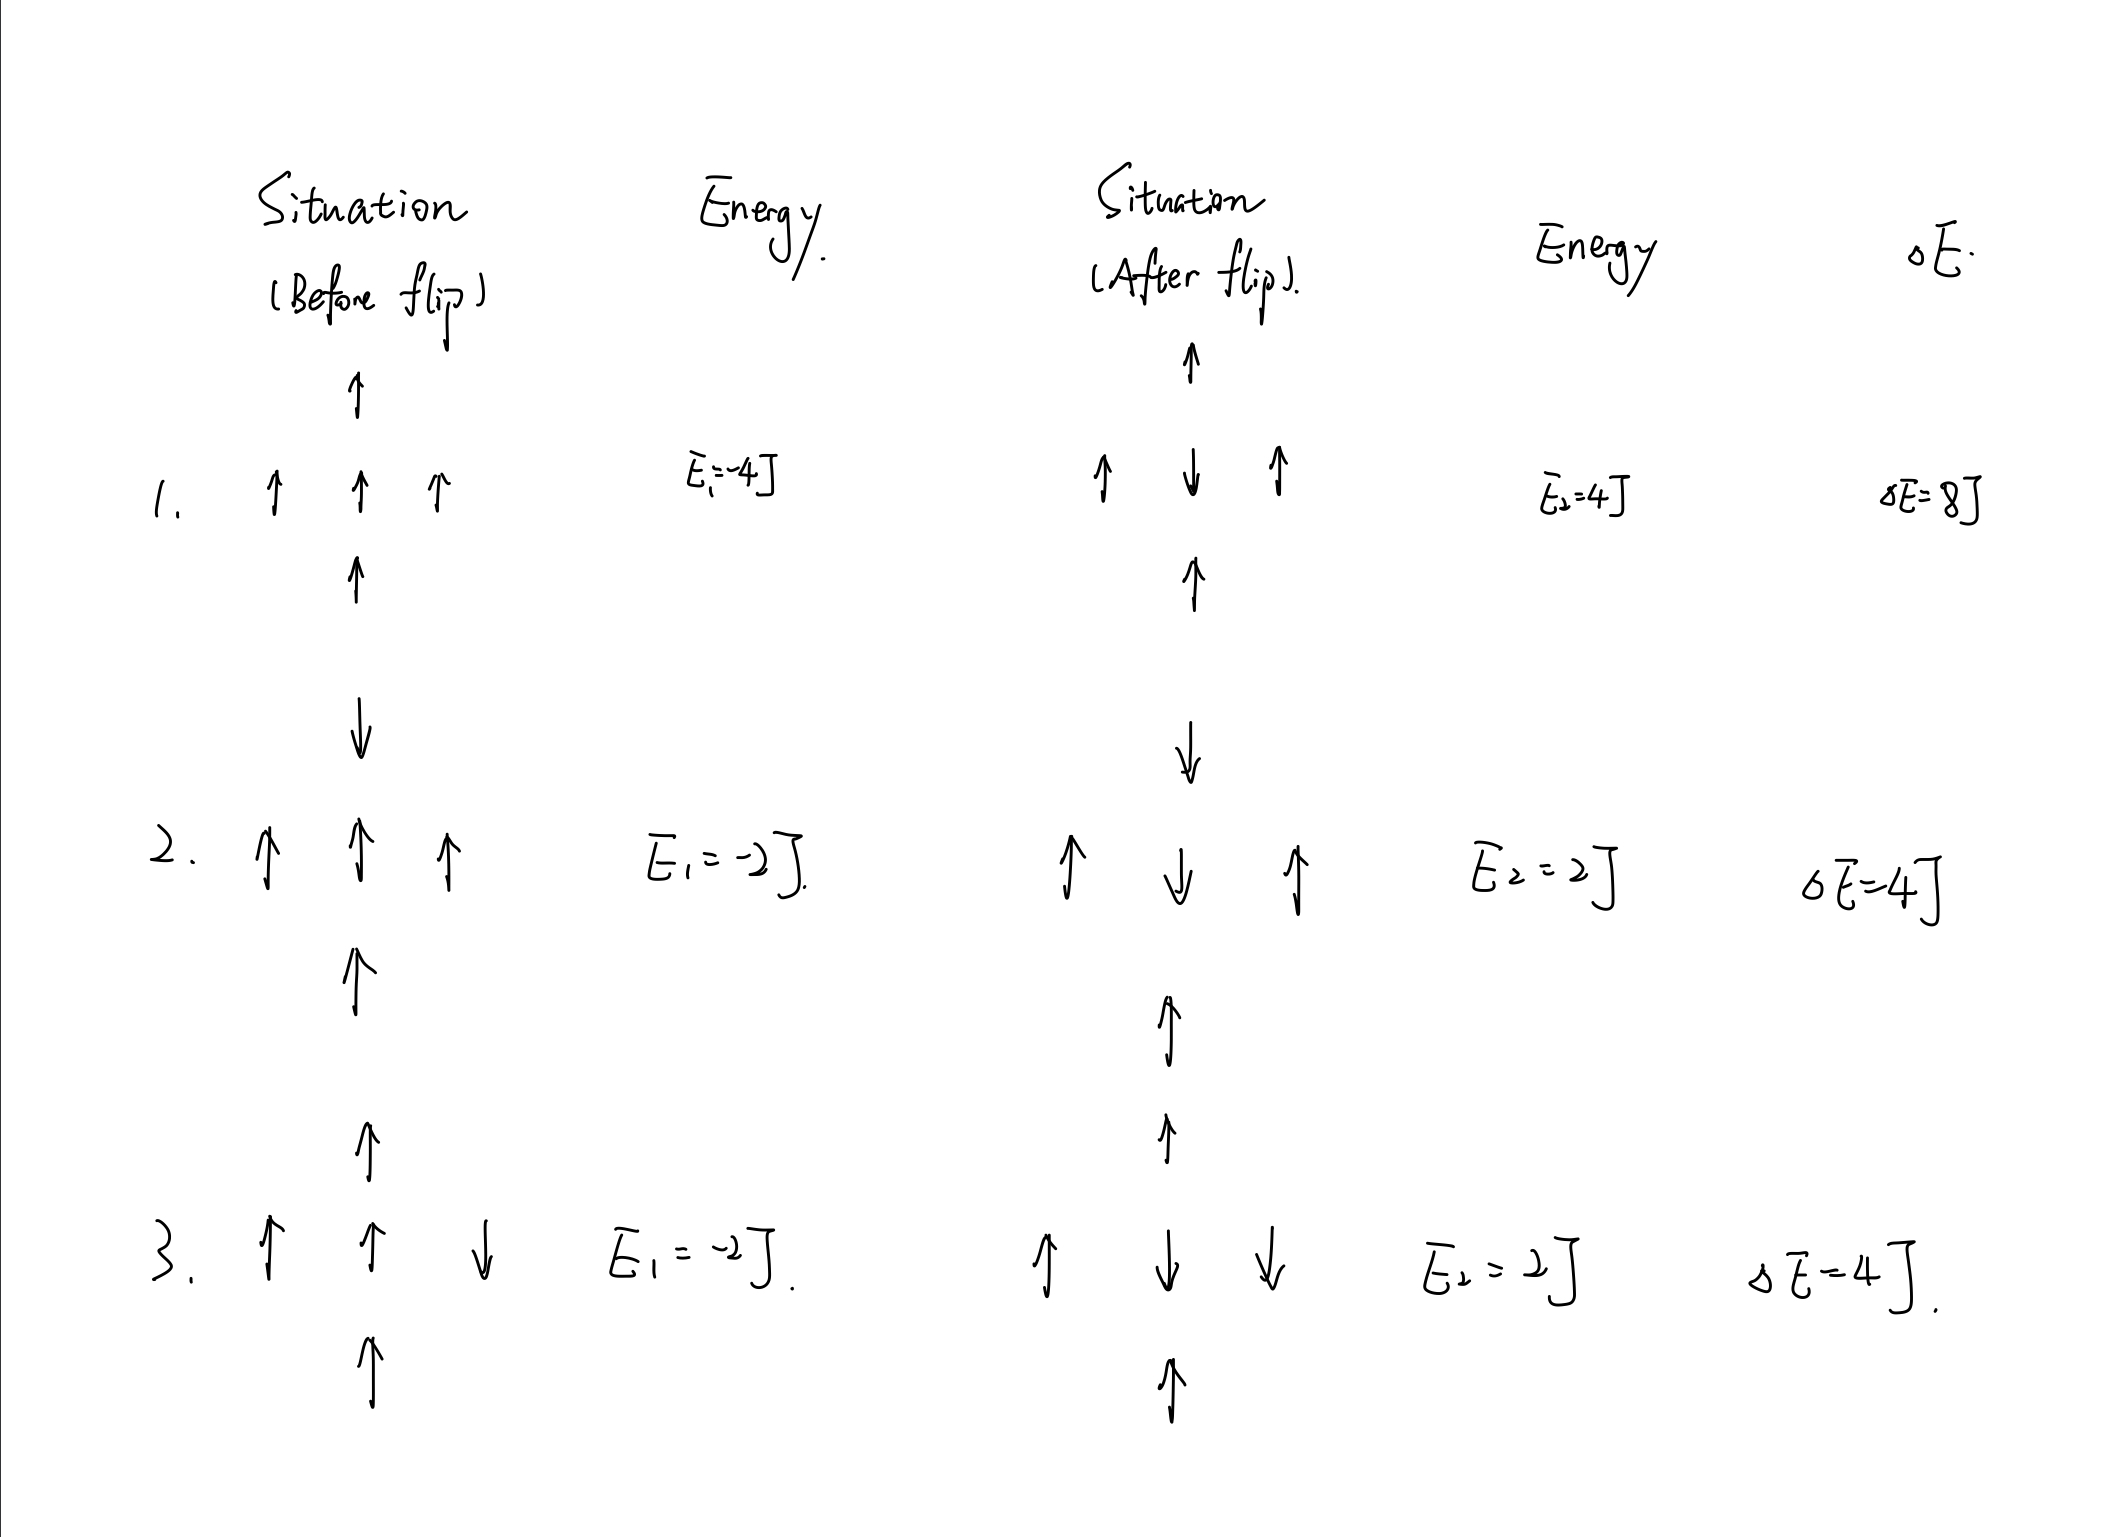

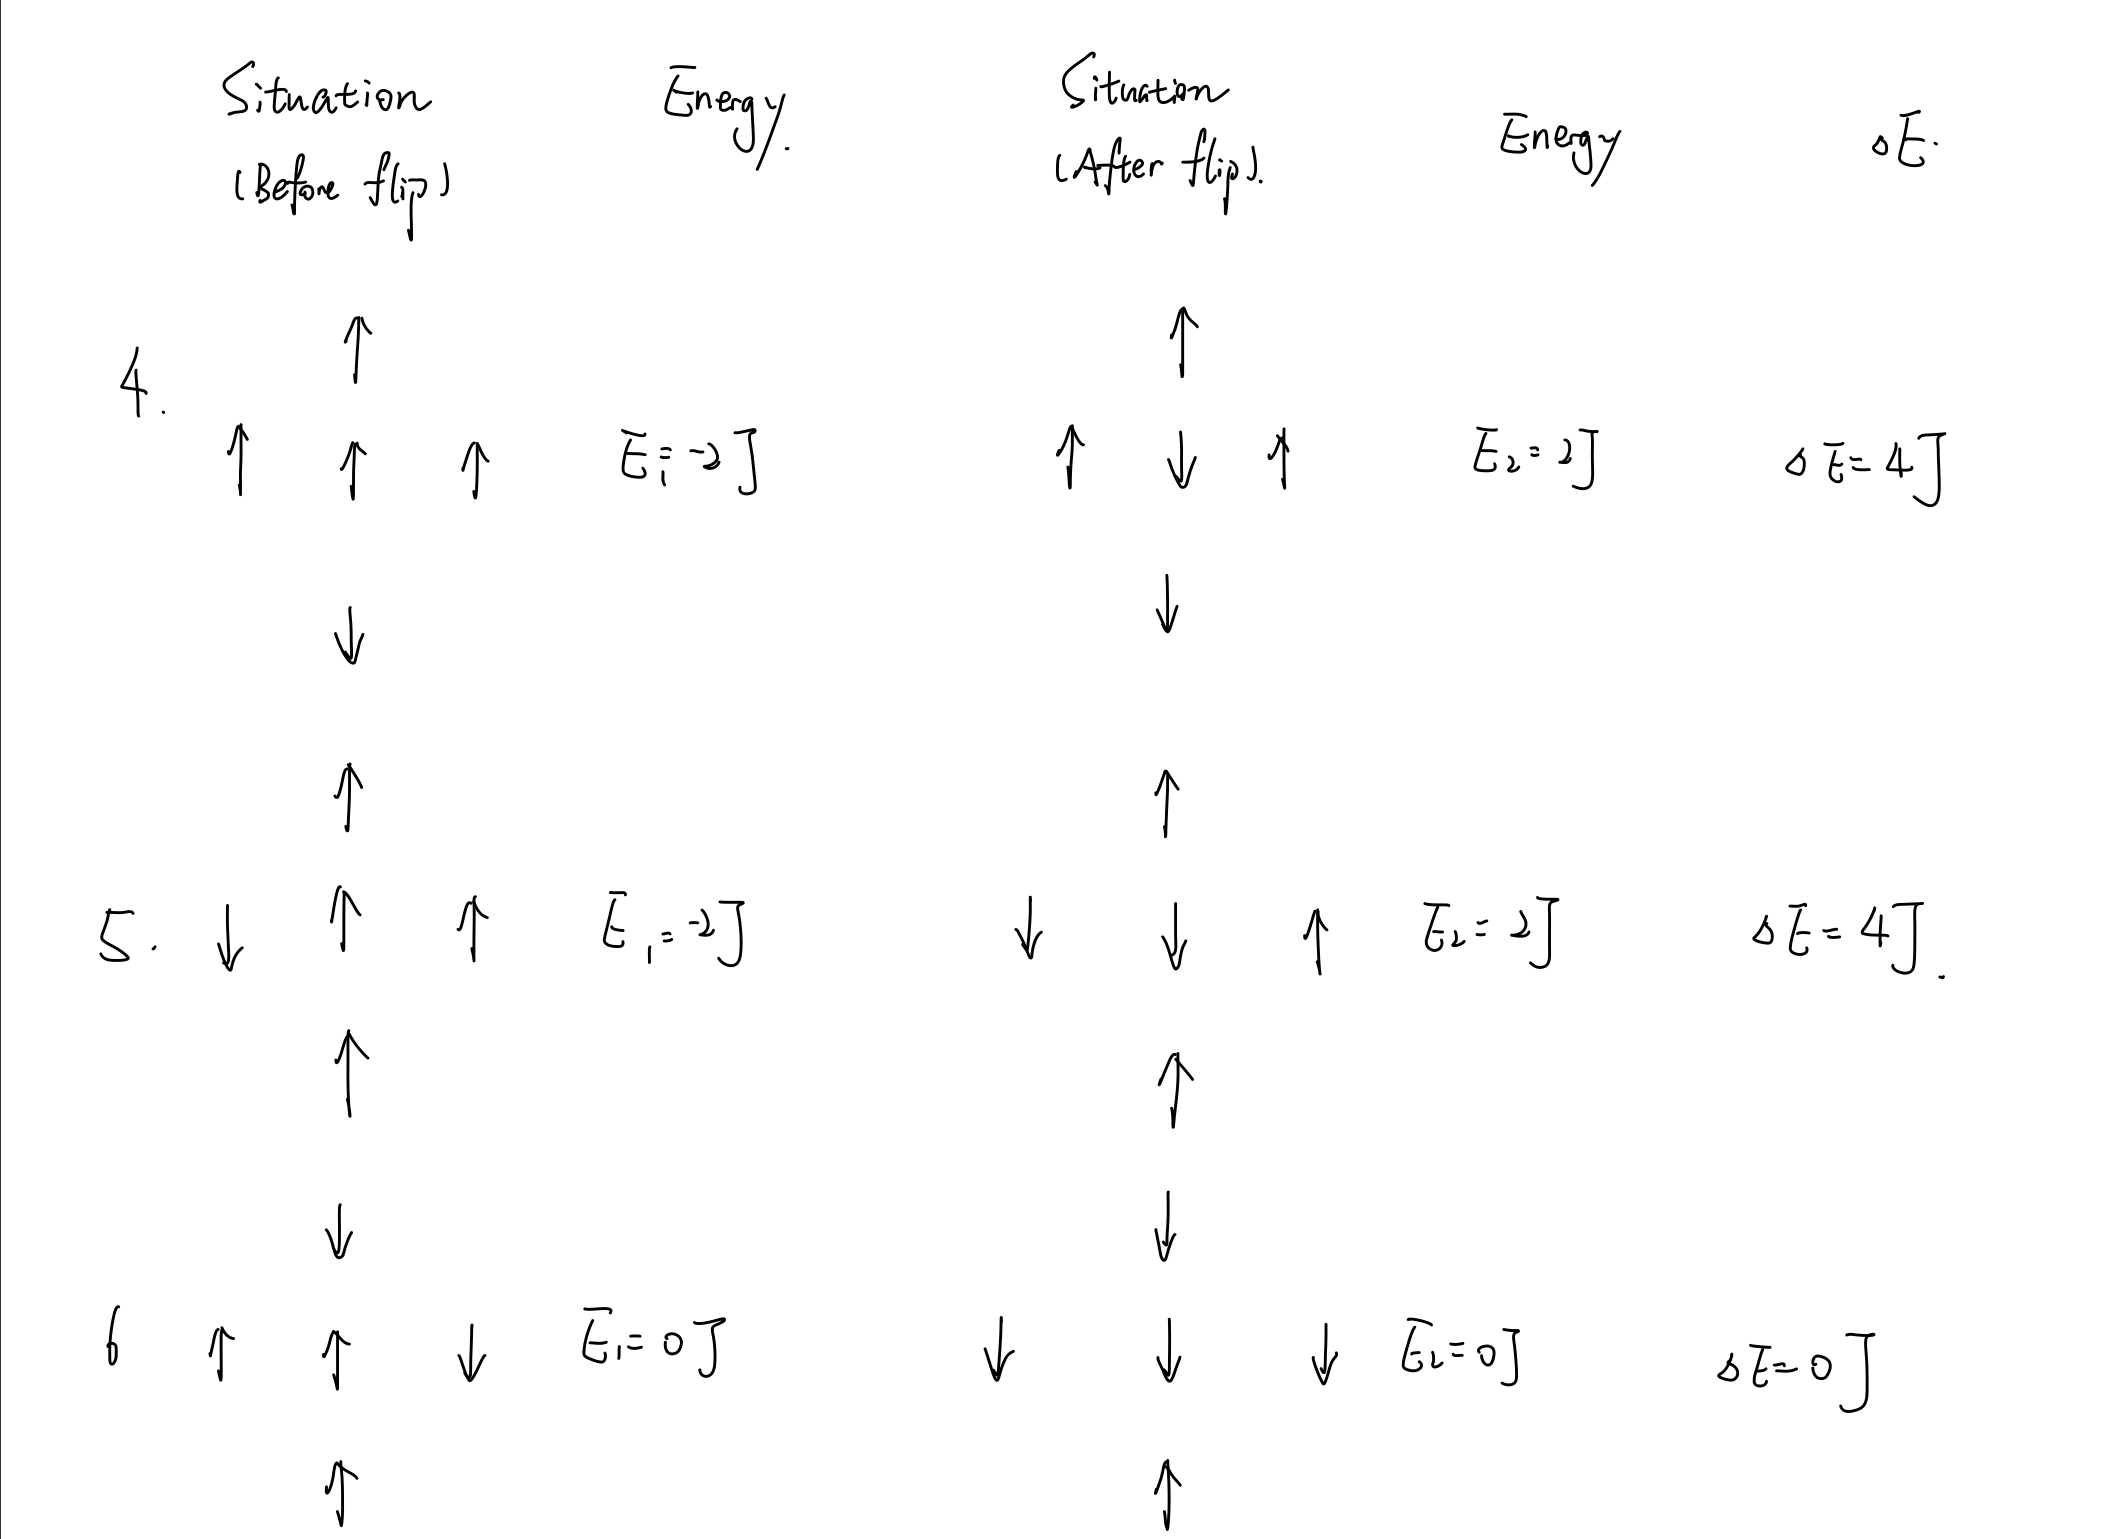

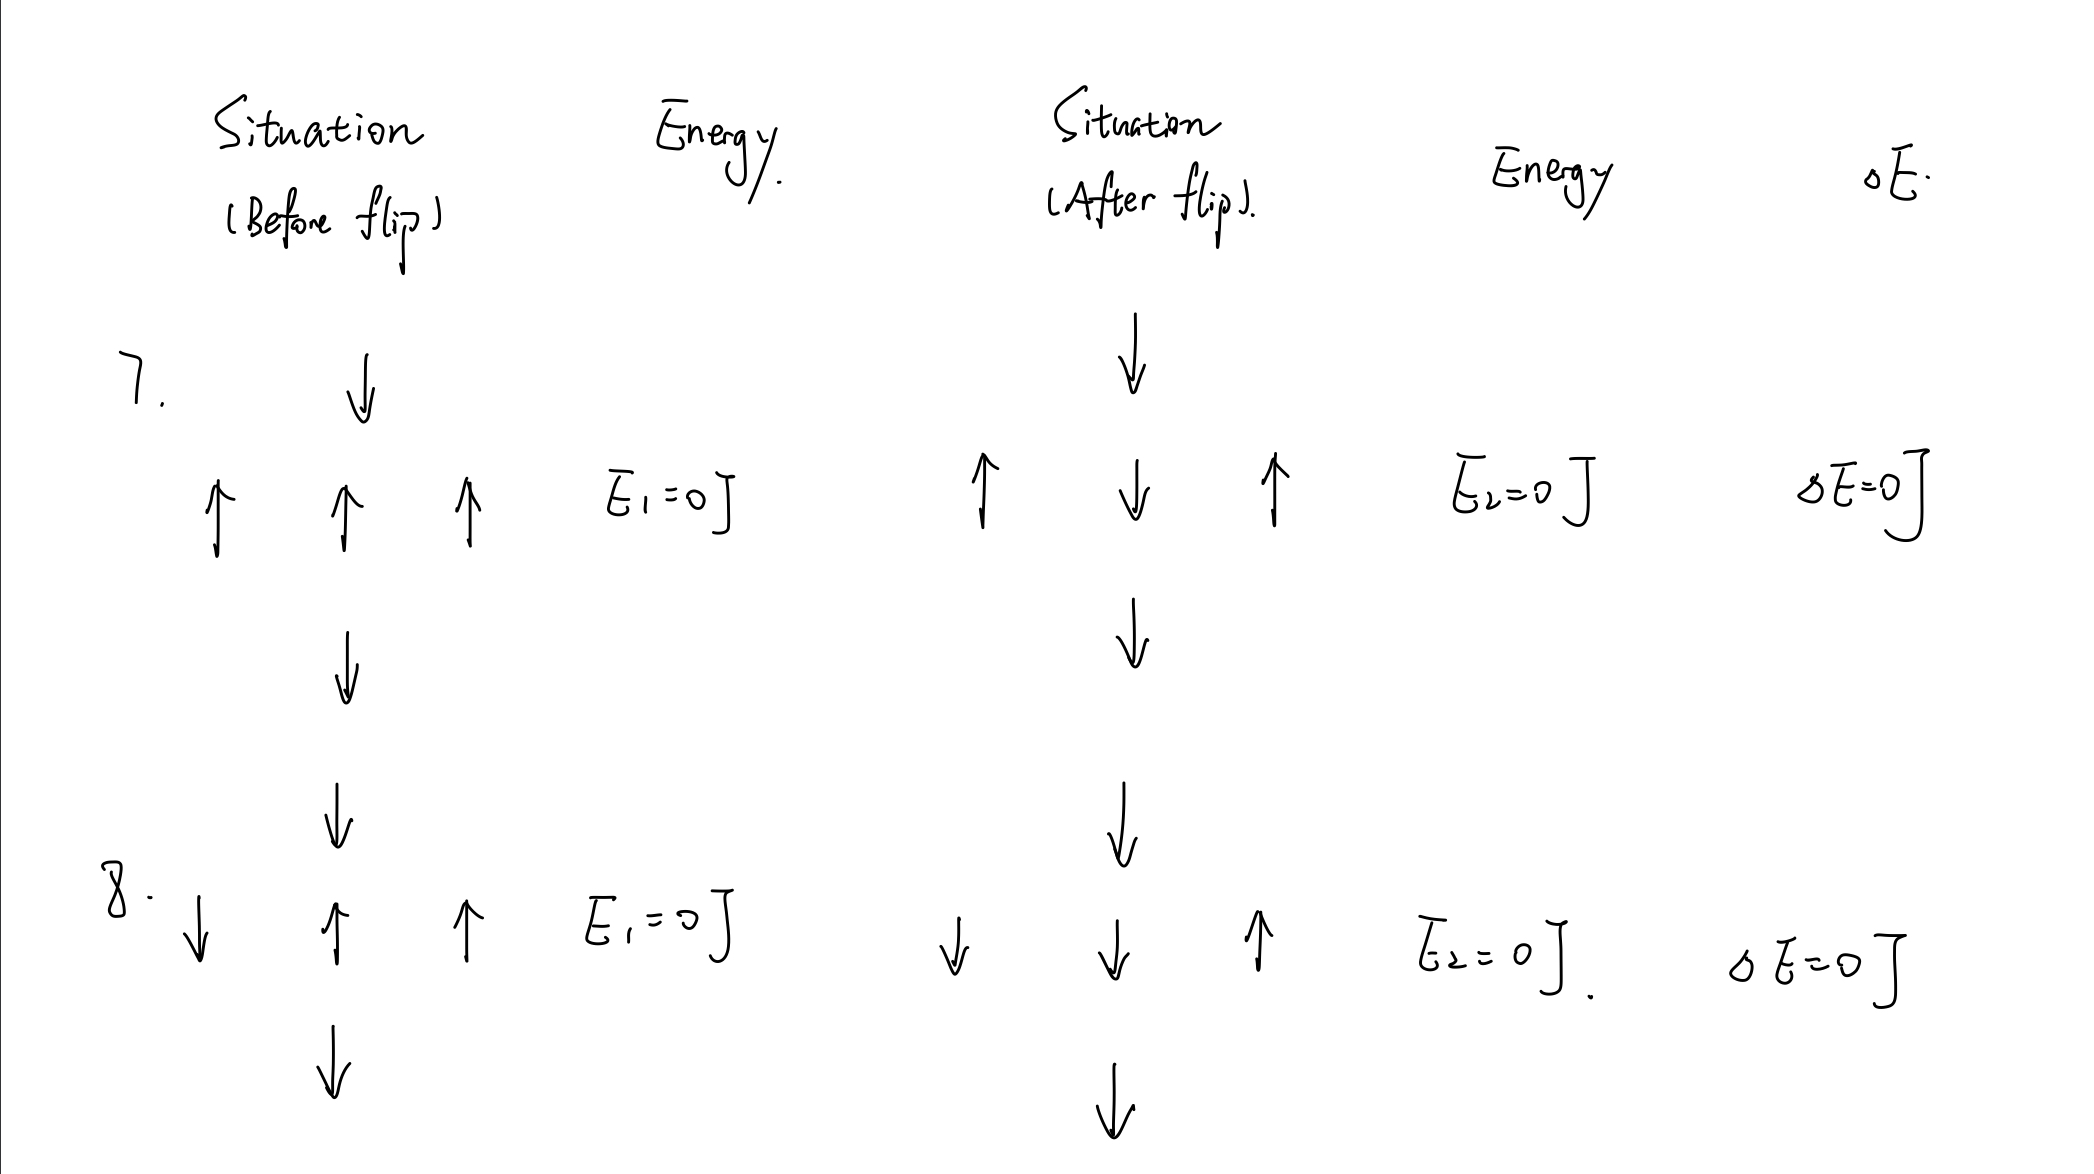

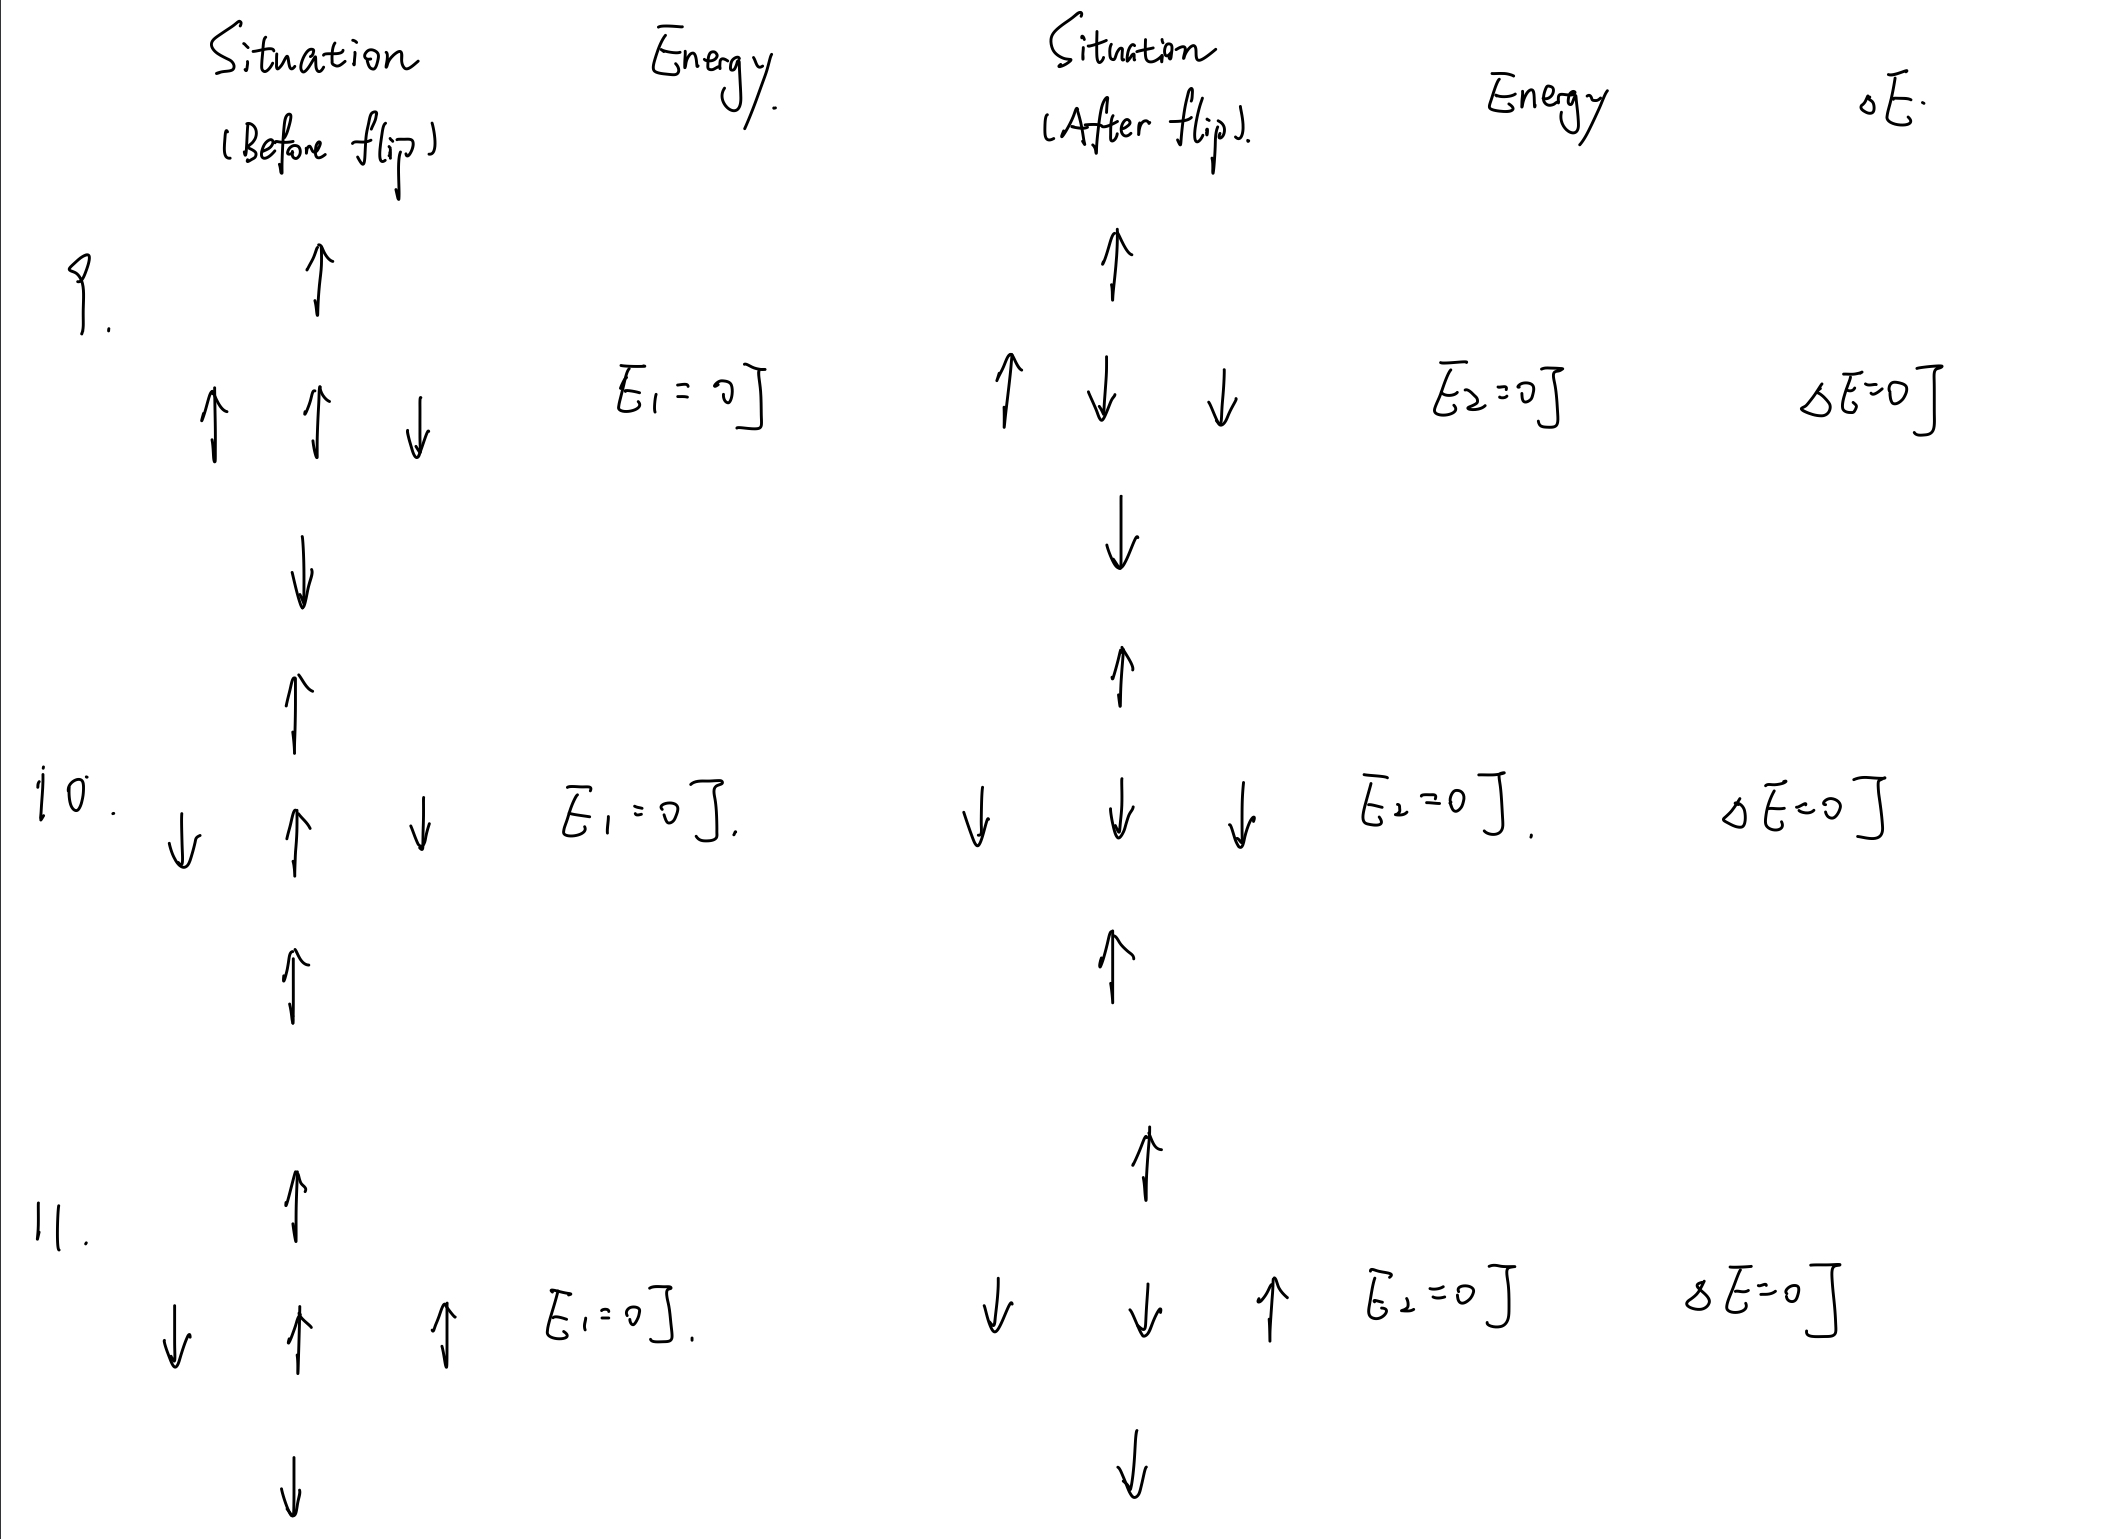

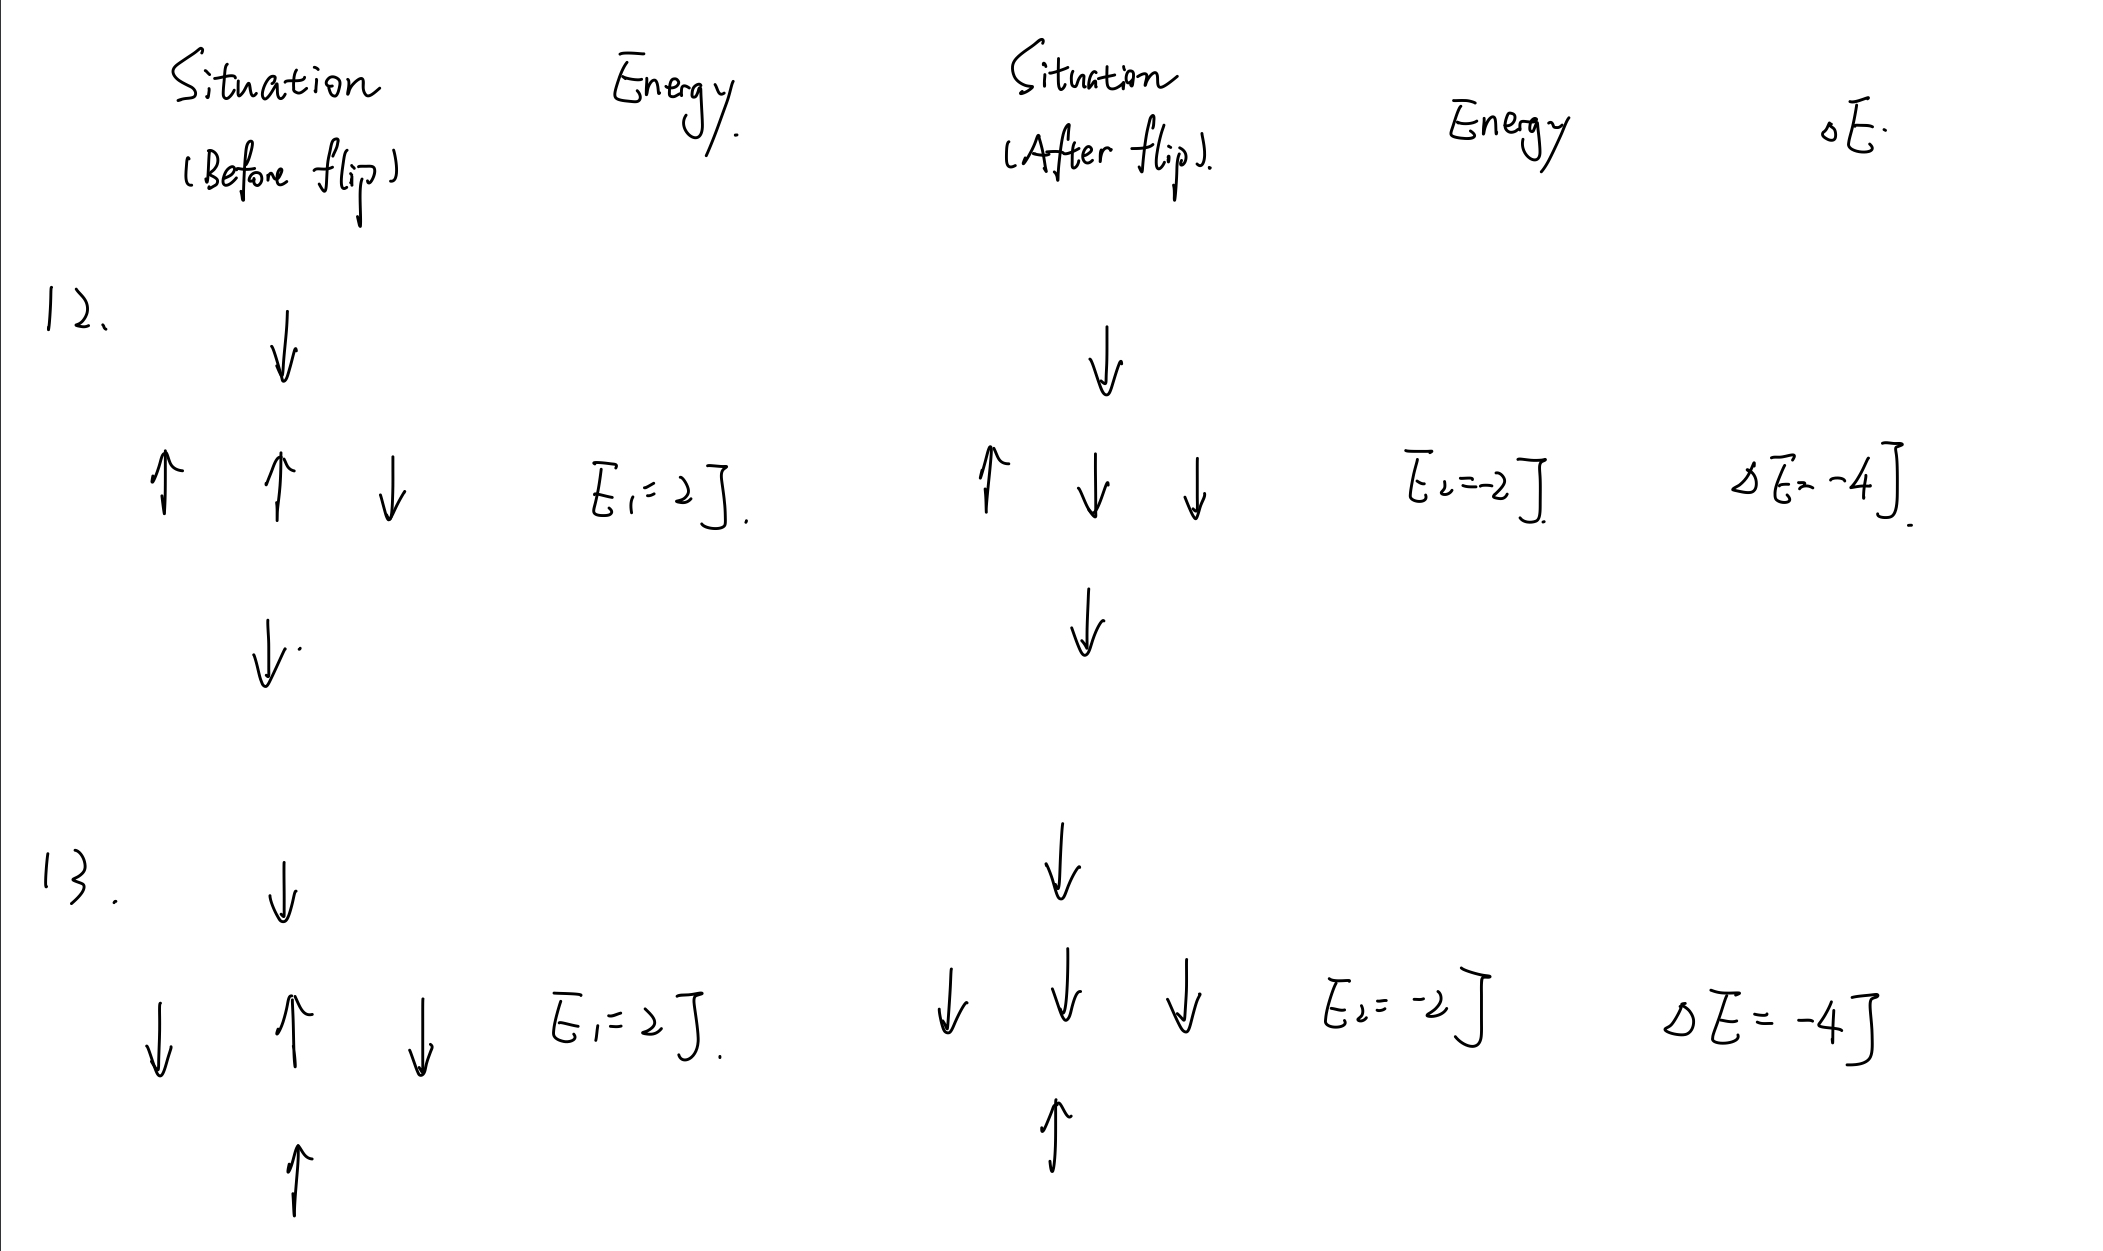

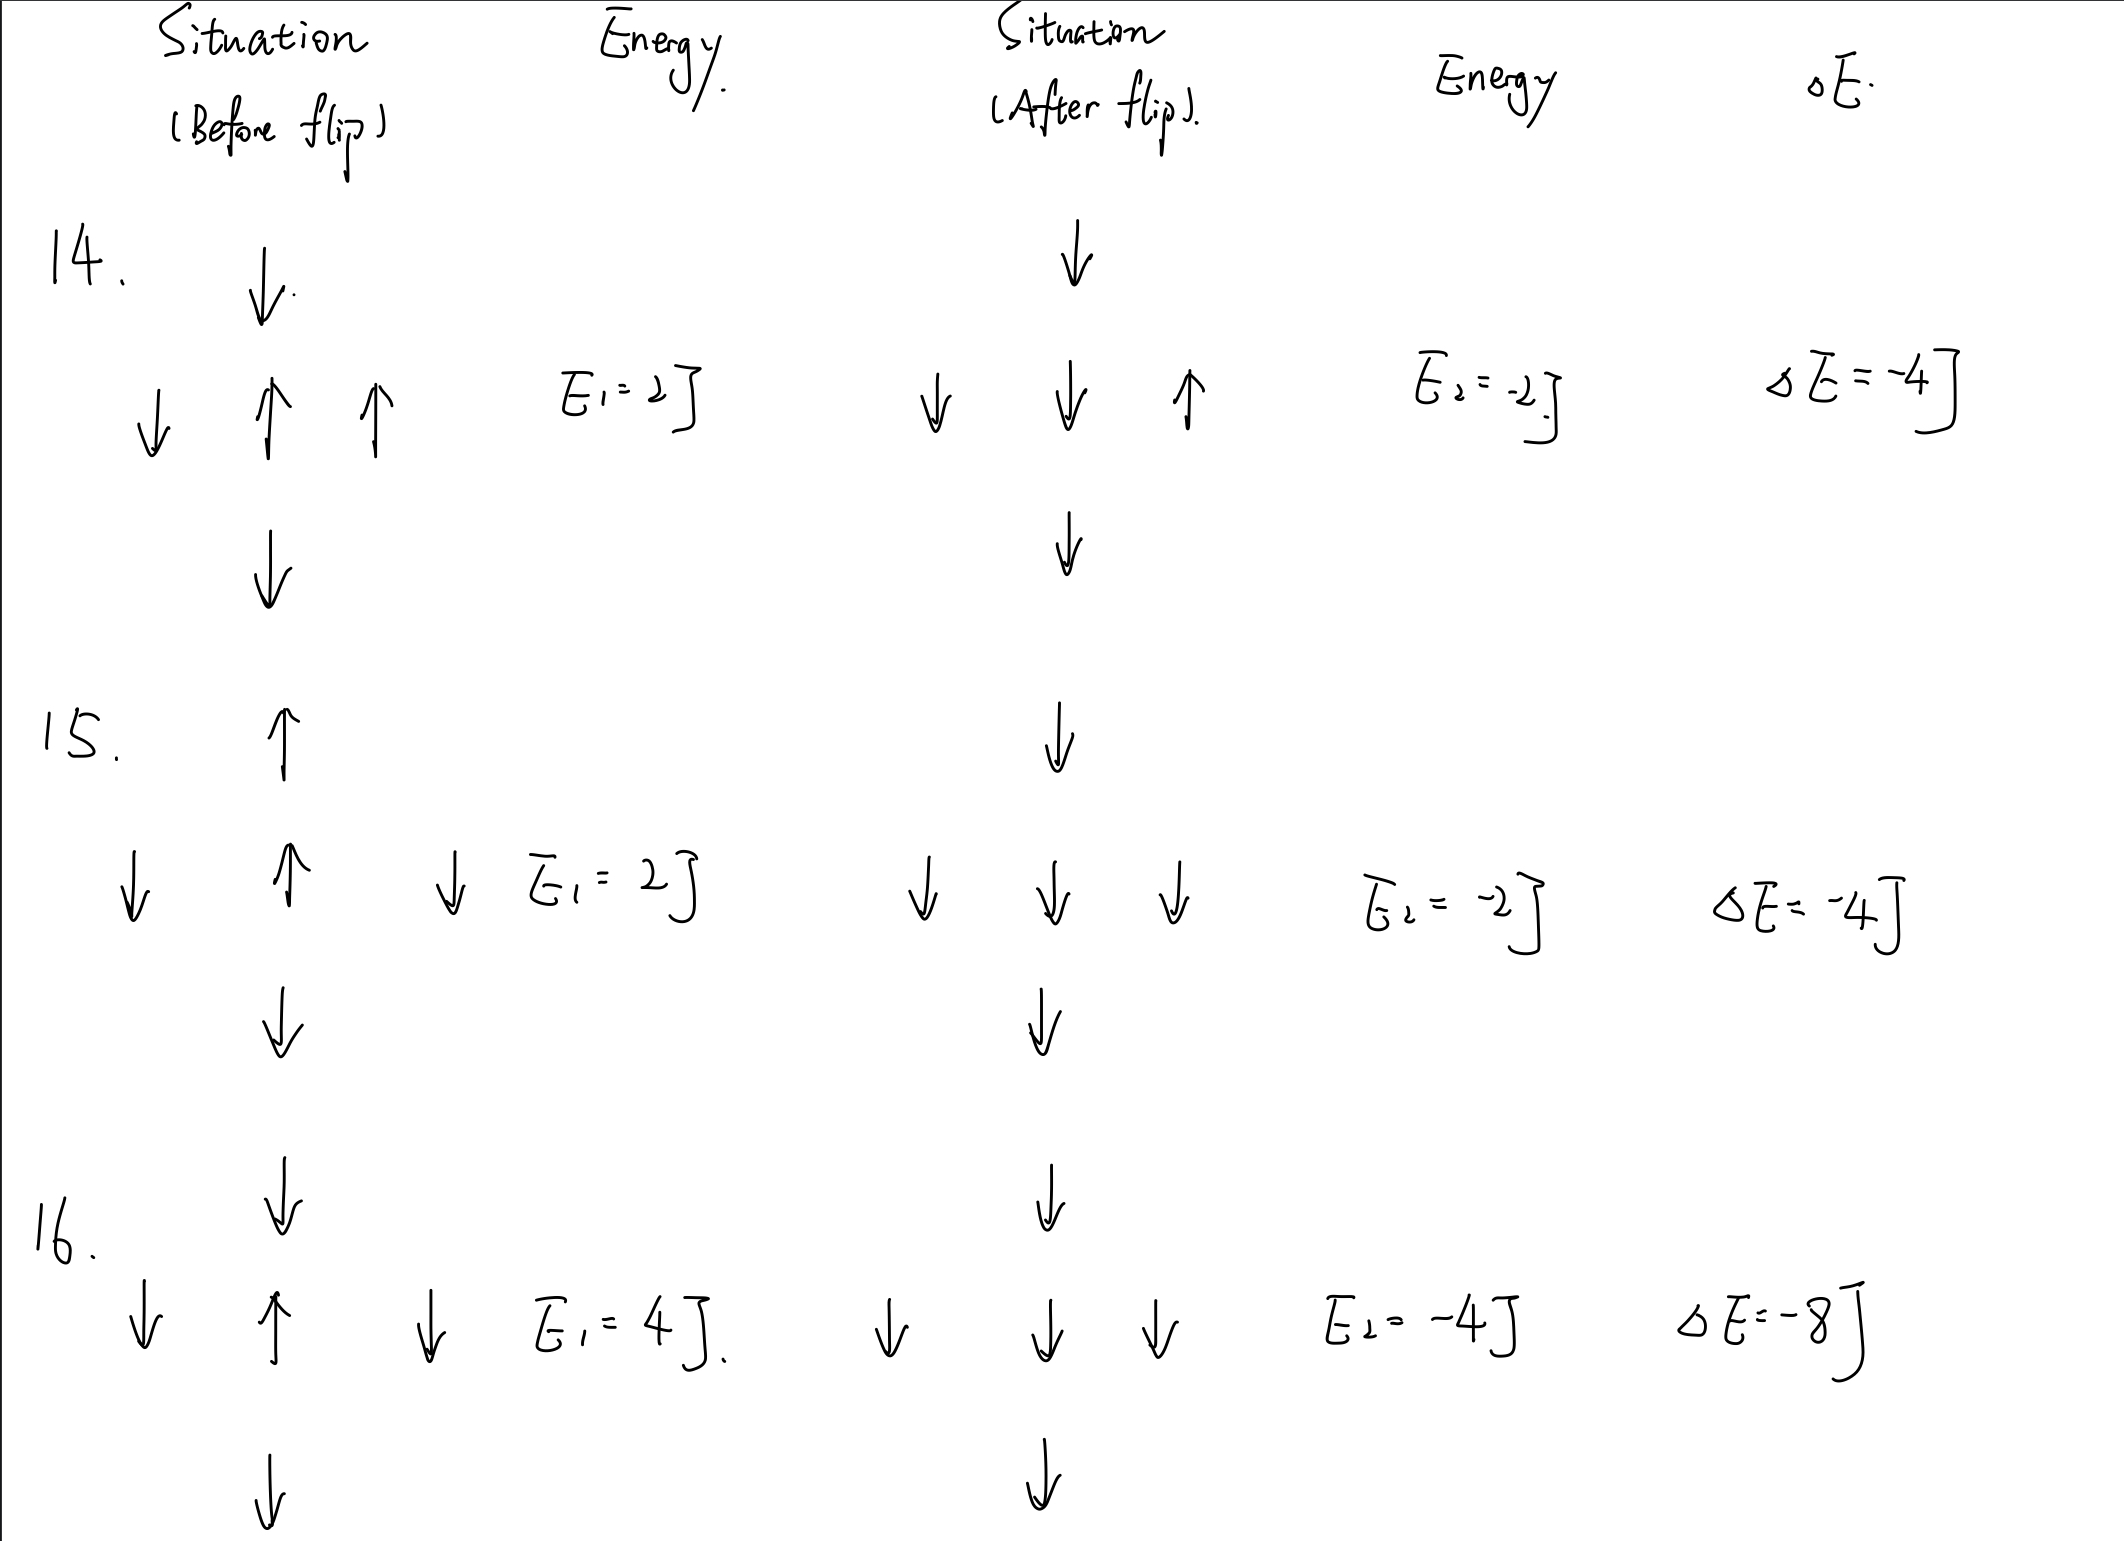

By analyzing the all the 32 situations, we learn that the only situations that will cause a positive energy change after a flip are: \
4 neighbor spins up and middle spin up \
3 neighbor spins up and middle spin up \
1 neighbor spins up and middle spin down \
0 neighbor spins up and middle spin down

So, we can get the following circuit (not optimized)

### Quantum (+ Classic) Algorithm

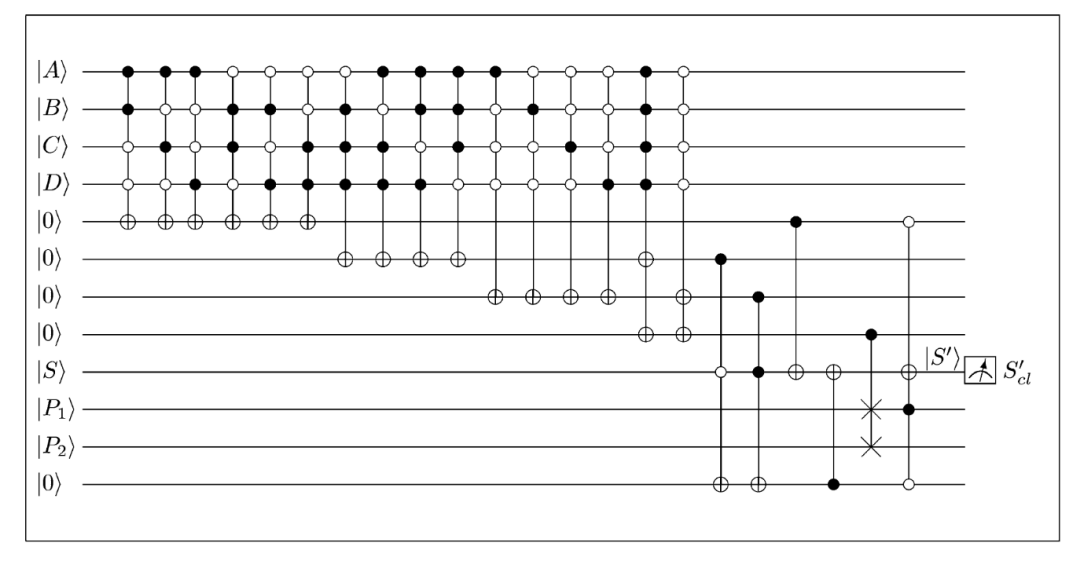

*This graph is from the 2004 paper*

And the code implementation:

In [183]:
# Quantum Cirucit
def twoDwithoutH(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[9])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[10])

    if spins[rindex][cindex] == 1:
        qc.x(q[8])
            
    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[0])

    if spins[rindex - 1][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[2])
    
    if spins[rindex][cindex - 1] == 1:
        qc.x(q[3])
    
    # Operation 1
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[2])
    qc.x(q[3])

    # Operation 2
    qc.x(q[1])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[1])
    qc.x(q[3])
    
    # Operation 3
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[0])
    qc.x(q[3])
    
    # Operation 5
    qc.x(q[0])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[0])
    qc.x(q[2])
    
    # Operation 6
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2], q[3]], q[4])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 7
    qc.x(q[0])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[0])
    
    # Operation 8
    qc.x(q[1])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[1])
    
    # Operation 9
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[2])
    
    # Operation 10
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.x(q[3])
    
    # Operation 11
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    
    # Operation 12
    qc.x(q[0])
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[0])
    qc.x(q[2])
    qc.x(q[3])
    
    # Operation 13
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[3])
    
    # Operation 14
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 15
    qc.mcx([q[0],q[1],q[2], q[3]], q[5])
    qc.cx(q[5], q[7])
    
    # Operation 16
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    qc.mcx([q[0],q[1],q[2], q[3]], q[6])
    qc.cx(q[6], q[7])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    
    # Operation 17
    qc.x(q[8])
    qc.ccx(q[5], q[8], q[11])
    qc.x(q[8])
    
    # Operation 18
    qc.ccx(q[6], q[8], q[11])
    
    # Operation 19
    qc.cx(q[4], q[8])
    
    # Operation 20
    qc.cx(q[11], q[8])
    
    # Operation 21
    qc.cswap(q[7], q[9], q[10])
    
    # Operation 22
    qc.x(q[4])
    qc.x(q[11])
    qc.mcx([q[4], q[9], q[11]],q[8])
    qc.x(q[4])
    qc.x(q[11])
    
    # Operation 23
    qc.measure(q[8], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[rindex][cindex] = 1
    elif newstat == 0:
        spins[rindex][cindex] = -1

69.29948616027832 seconds
{'[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 25, '[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 30, '[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 23, '[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 22}


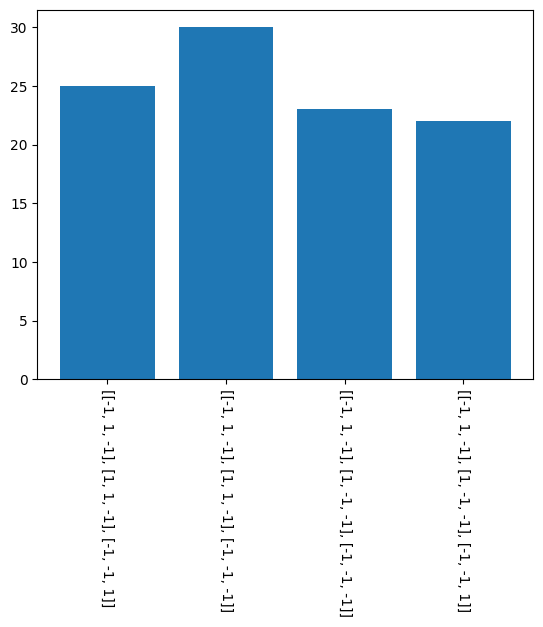

In [184]:
start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 3 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)


# Initialize the circuit
q = QuantumRegister(12)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for t in range(100):
    
    spins = s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]
    
    for temp10 in range (0, L):
        for temp11 in range (0, L):
            twoDwithoutH(temp10, temp11)
    
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plotdyct(dyct)

### Classic Monte Carlo Algorithm

In order to make sure the quantum algorithm is functioning well, we can write a classic monte carlo version

In [ ]:
# Define a function to calculate the energy of the lattice
def calculate_energy(s, rindex, cindex):
    energy = 0
    energy = -J * s[rindex][cindex] * (s[rindex - 1][cindex] + s[(rindex + 1) % L][cindex]
                    + s[rindex][(cindex + 1) % L] + s[rindex][cindex - 1] )
    return energy

def deltaEnergy(s, rindex, cindex):
    temps = copy.deepcopy(s)
    temps[rindex][cindex] = -1 * temps[rindex][cindex]
    return calculate_energy(temps, rindex, cindex) - calculate_energy(s, rindex, cindex)

In [ ]:
# Define parameters
J = -0.125 * np.log(0.5)  # coupling constant
k_B = 1.0  # Boltzmann constant
T = 1.0  # temperature
L = 3   # lattice size
N = L**2  # number of spins
n_steps = 1000  # number of simulation steps
dyct = {}

# Initialize the lattice
#s = np.random.choice([-1, 1], size=(L, L))
#s = [[1 for col in range(L)] for row in range(L)]
s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]


# Monte Carlo simulation using the Metropolis algorithm
for step in range(n_steps):
    #Initialize Spin for every loop
    st = copy.deepcopy(s)
    
    # Calculate the energy change and perform ising interaction
    for i in range(L):
        for j in range(L):
            if deltaEnergy(st, i, j) <= 0:
                st[i][j] = -1 * st[i][j]
            else:
                if random.random() < np.exp(-deltaEnergy(st, i, j)/(k_B*T)):
                    st[i][j] = -1 * st[i][j]
    # Added result to dictionary
    encode(dyct, st)
    

#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in s]))

print(dyct)
plotdyct(dyct)

*This code is first written by ChatGPT and modified by Zihan Li*

### Optimal Quantum (+ Classic) Algorithm

The circuit above clearly shows the correspondence between different spin configurations and probabilities. However, it can be done faster. Below is an idea for optimizaiton.

The idea is to treat the 2D ising model as 2 1D ising model. The first ising model is consists of the upper neighbor, the middle spin, and the lower neighbor, while the second ising model is consists of the left neighbor, the middle spin, and the right neighbor. It also make sense mathematically.

The formula of calculating a 2D ising system's energy is: (Suppose A for the upper neighbor, D for the lower neighbor, B for the left neighbor, C for the right neighbor, and S for the middle spin)
$$
E = -J*(S*(A+B+C+D))
$$
It can be rewritten as 
$$
E = -J(S*A + S*D) + (-J)*(S*B + S*C)
$$
which is the energy of 2 1D ising model.

There are only 2 exceptions, number 7 and 10 of the 16 possible situations. If we treat them as 2 1D ising model, the total energy change should be positive since the horizontal/vertical is a positive energy change situation while the vertical/horizontal one isn't (the left column). However, the reality is that the total energy change is zero, and here is the explanation. When we look at the left column only for number 7 and 10, the horizontal/vertical 1D ising model is a positive energy cahnge situation while the vertical/horizontal one is in a 0 energy change situation. After the flip, the horizontal/vertical 1D Ising model turns into 0 energy change situation while the vertical/horizontal one turns into a positve energy change situation. The energy of the system is conserved. 

Based on that, the circuit can be constructed in the following way:

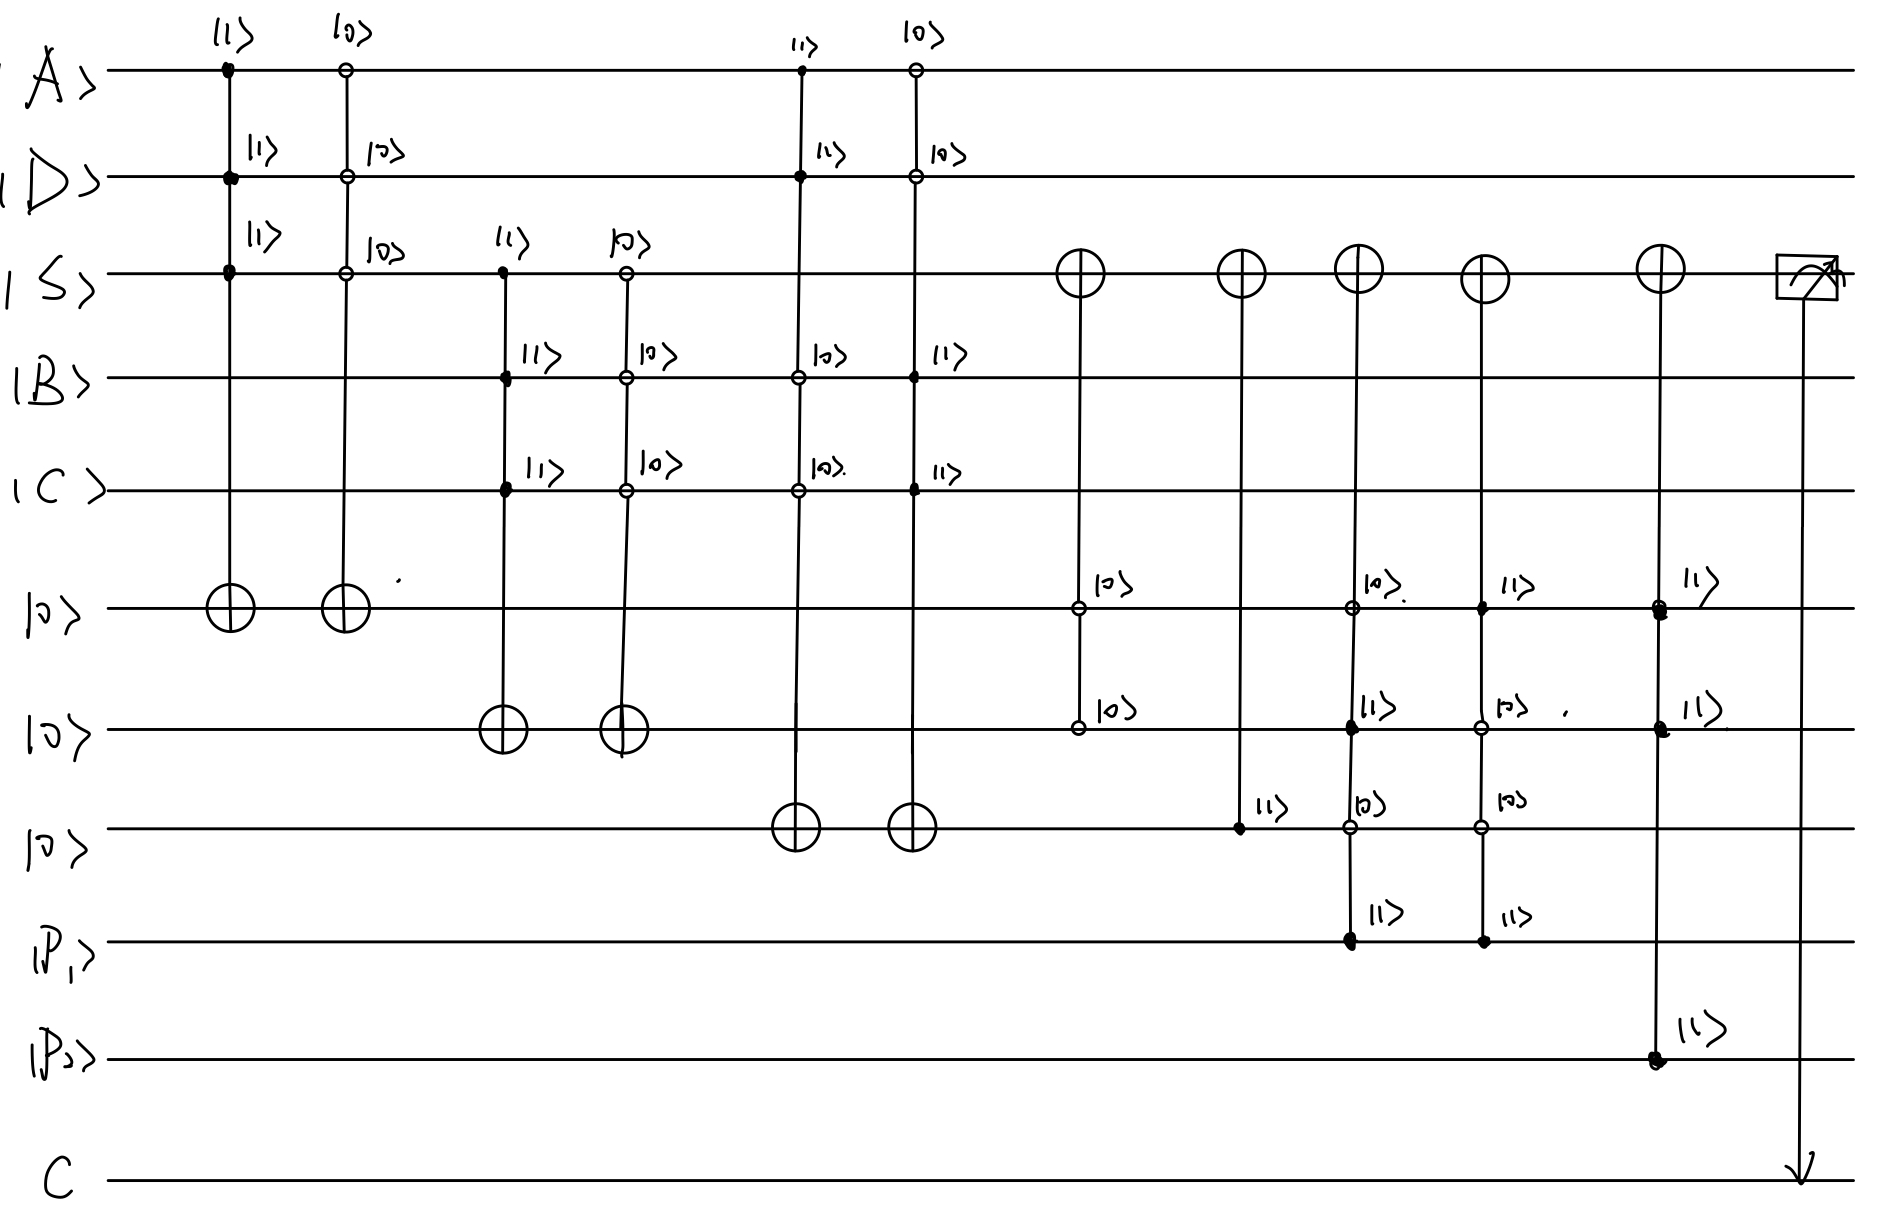

It is implemented with following codes:

In [9]:
def withoutH21D(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[8])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[9])

    if spins[rindex][cindex] == 1:
        qc.x(q[2])
            
    if spins[(rindex - 1) % L][cindex] == 1:
        qc.x(q[0])

    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][(cindex - 1) % L] == 1:
        qc.x(q[3])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[4])
    
    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[5])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[0], q[1], q[2]], q[5])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    
    # Operation 3
    qc.mcx([q[2], q[3], q[4]], q[6])
    
    # Operation 4
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[2], q[3], q[4]], q[6])
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[0], q[1], q[3], q[4]], q[7])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 6
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0], q[1], q[3], q[4]], q[7])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 7
    qc.x(q[5])
    qc.x(q[6])
    qc.ccx(q[5], q[6], q[2])
    qc.x(q[5])
    qc.x(q[6])
    
    # Operation 8
    qc.cx(q[7], q[2])
    
    # Operation 9
    qc.mcx([q[5], q[6], q[9]], q[2])
    
    # Operation 10
    qc.x(q[5])
    qc.x(q[7])
    qc.mcx([q[5], q[6], q[7], q[8]], q[2])
    qc.x(q[5])
    qc.x(q[7])
    
    # Operation 11
    qc.x(q[6])
    qc.x(q[7])
    qc.mcx([q[5], q[6], q[7], q[8]], q[2])
    qc.x(q[6])
    qc.x(q[7])
    
    
    # Operation 12
    qc.measure(q[2], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[rindex][cindex] = 1
    elif newstat == 0:
        spins[rindex][cindex] = -1

153.7150115966797 seconds
{'[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 19, '[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 26, '[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 32, '[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 23}


<BarContainer object of 4 artists>

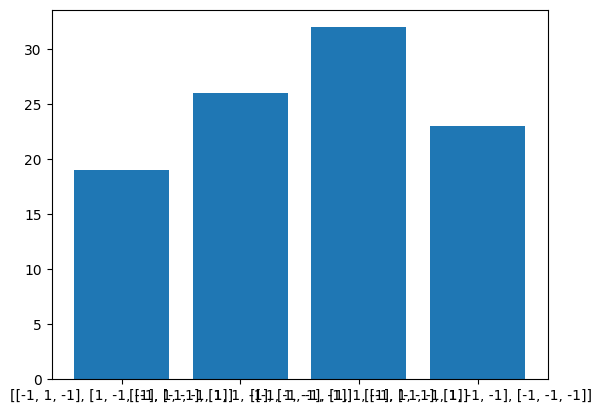

In [10]:
start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 3 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)


# Initialize the circuit
q = QuantumRegister(10)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for t in range(100):
    
    spins = s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]
    
    for temp10 in range (0, L):
        for temp11 in range (0, L):
            withoutH21D(temp10, temp11)
    
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plt.bar(dyct.keys(), dyct.values())

It turned out that this algorithm is faster than the 2004 paper's. Moreover, this also indicates for a n-dimensional ising model, we can treat it as n 1D ising model, while leaving the speical situation.

In [169]:
# Define a function to calculate the energy of the lattice
def calculate_energy(s, rindex, cindex):
    energy = 0
    energy = -J * s[rindex][cindex] * (s[rindex - 1][cindex] + s[(rindex + 1) % L][cindex]
                    + s[rindex][(cindex + 1) % L] + s[rindex][cindex - 1] )
    return energy

def deltaEnergy(s, rindex, cindex):
    temps = copy.deepcopy(s)
    temps[rindex][cindex] = -1 * temps[rindex][cindex]
    return calculate_energy(temps, rindex, cindex) - calculate_energy(s, rindex, cindex)

{'[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 233, '[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 254, '[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 234, '[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 279}


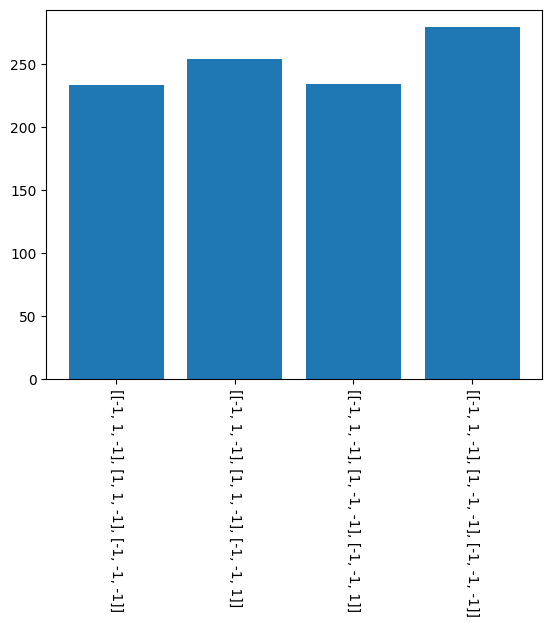

In [170]:
# Define parameters
J = -0.125 * np.log(0.5)  # coupling constant
k_B = 1.0  # Boltzmann constant
T = 1.0  # temperature
L = 3   # lattice size
N = L**2  # number of spins
n_steps = 1000  # number of simulation steps
dyct = {}

# Initialize the lattice
#s = np.random.choice([-1, 1], size=(L, L))
#s = [[1 for col in range(L)] for row in range(L)]
s = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]


# Monte Carlo simulation using the Metropolis algorithm
for step in range(n_steps):
    #Initialize Spin for every loop
    st = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]
    
    # Calculate the energy change and perform ising interaction
    for i in range(L):
        for j in range(L):
            if deltaEnergy(st, i, j) <= 0:
                st[i][j] = -1 * st[i][j]
            else:
                if random.random() < np.exp(-deltaEnergy(st, i, j)/(k_B*T)):
                    st[i][j] = -1 * st[i][j]
    # Added result to dictionary
    encode(dyct, st)
    

#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in s]))

print(dyct)
plotdyct(dyct)

In [102]:
def withoutH21Duptest(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(P1)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(P2)), 0, 0, q[8])

            
    if spins[rindex - 1][cindex] == 1:
        qc.x(q[0])

    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][cindex - 1] == 1:
        qc.x(q[3])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[4])
    
    # Operation 1
    qc.mcx([q[0], q[1], q[3], q[4]], q[5])

    # Operation 2
    qc.ccx(q[0], q[1], q[6])

    # Operation 3
    qc.ccx(q[3], q[4], q[6])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0], q[1], q[3], q[4]], q[6])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[0], q[1], q[3], q[4]], q[6])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 6
    qc.x(q[6])
    qc.mcx([q[5], q[6], q[8]], q[2])
    qc.x(q[6])
    
    # Operation 7
    qc.ccx(q[6], q[7], q[2])

    # Operation 8
    qc.measure(q[2], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return int(list(counts.keys())[0])

def withoutH21Ddowntest(rindex, cindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(P1)), 0, 0, q[7])
    qc.u(2 * np.arccos(np.sqrt(P2)), 0, 0, q[8])

            
    if spins[rindex - 1][cindex] == 1:
        qc.x(q[0])

    if spins[(rindex + 1) % L][cindex] == 1:
        qc.x(q[1])
    
    if spins[rindex][cindex - 1] == 1:
        qc.x(q[3])
    
    if spins[rindex][(cindex + 1) % L] == 1:
        qc.x(q[4])
    
    # Operation 1
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[0], q[1], q[3], q[4]], q[5])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[3])
    qc.x(q[4])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.ccx(q[0], q[1], q[6])
    qc.x(q[0])
    qc.x(q[1])

    # Operation 3
    qc.x(q[3])
    qc.x(q[4])
    qc.ccx(q[3], q[4], q[6])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[1])
    qc.mcx([q[0], q[1], q[3], q[4]], q[6])
    qc.x(q[0])
    qc.x(q[1])
    
    # Operation 5
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[0], q[1], q[3], q[4]], q[6])
    qc.x(q[3])
    qc.x(q[4])
    
    # Operation 6
    qc.x(q[6])
    qc.mcx([q[5], q[6], q[8]], q[2])
    qc.x(q[6])
    
    # Operation 7
    qc.ccx(q[6], q[7], q[2])

    # Operation 8
    qc.measure(q[2], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return int(list(counts.keys())[0])

68.67772054672241 seconds
{'[[-1, 1, -1], [1, 1, -1], [-1, -1, 1]]': 26, '[[-1, 1, -1], [1, -1, -1], [-1, -1, -1]]': 31, '[[-1, 1, -1], [1, -1, -1], [-1, -1, 1]]': 19, '[[-1, 1, -1], [1, 1, -1], [-1, -1, -1]]': 24}


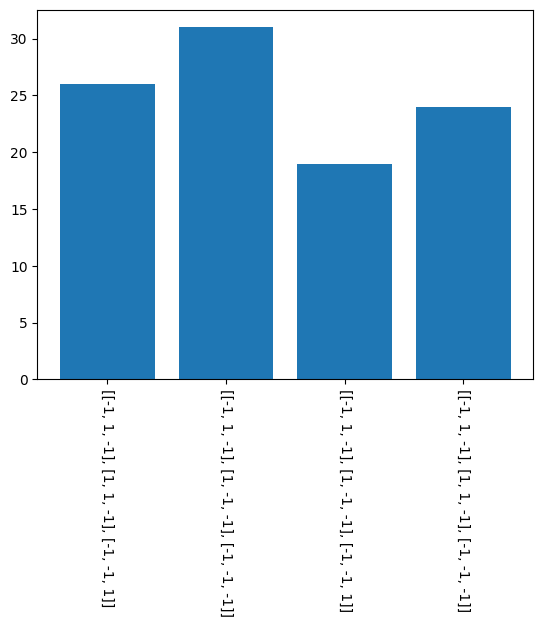

In [186]:
start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 3 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)


# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for t in range(100):
    
    spins = [[1, -1, 1], [-1, 1, 1], [1, 1, -1]]
    
    for temp10 in range (0, L):
        for temp11 in range (0, L):
            if spins[temp10][temp11] > 0:
                spins[temp10][temp11] = spins[temp10][temp11] * (2 * withoutH21Duptest(temp10, temp11) - 1) * spins[temp10][temp11]
            else:
                spins[temp10][temp11] = spins[temp10][temp11] * (-2 * withoutH21Ddowntest(temp10, temp11) + 1) * spins[temp10][temp11]
    
    encode(dyct, spins)

print(float(time() - start), 'seconds')
print(dyct)
plotdyct(dyct)

In [168]:
#start = time()

# Set Parameters
J = -0.125*np.log(0.5) # Coupling Strength
T = 1 # Temperature
L = 3 # Dimensions
dyct = {} # Reocrd Dictionary

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)
result = {}

# Initialize the circuit
q = QuantumRegister(9)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)


for i in range(100):

    spins = [[1, -1, 1], [-1, 1, -1], [1, -1, -1]]
    
    if spins[1][1] > 0:
        spins[1][1] = spins[1][1] * (2 * withoutH21Duptest(1, 1) - 1) * spins[1][1]
    else:
        spins[1][1] = spins[1][1] * (-2 * withoutH21Ddowntest(1, 1) + 1) * spins[1][1]
    #result.append(withoutH21Dtest(1, 1))
    #spins[1][1] = spins[1][1] * (2 * withoutH21Duptest(1, 1) - 1) * spins[1][1]
    encode(result, spins[1][1])
print(result)

#spins[temp10][temp11] = spins[temp10][temp11] * indi * spins[temp10][temp11]
#encode(dyct, spins)

#print(float(time() - start), 'seconds')
#print(dyct)
#plt.bar(dyct.keys(), dyct.values())

{'-1': 100}


In [126]:
print()

In [13]:
# Define a function to calculate the energy of the lattice
def calculate_energy(s, xindex, yindex, zindex):
    energy = 0
    energy = -J * s[xindex][yindex][zindex] * (s[xindex - 1][yindex][zindex] + s[(xindex + 1) % L][yindex][zindex]
                    + s[xindex][(yindex + 1) % L][zindex] + s[xindex][yindex - 1][zindex] + s[xindex][yindex][(zindex + 1) % L]
                    + s[xindex][yindex][(zindex - 1) % L])
    return energy

def deltaEnergy(s, xindex, yindex, zindex):
    temps = copy.deepcopy(s)
    temps[xindex][yindex][zindex] = -1 * temps[xindex][yindex][zindex]
    return calculate_energy(temps, xindex, yindex, zindex) - calculate_energy(s, xindex, yindex, zindex)

0.6112329959869385 seconds


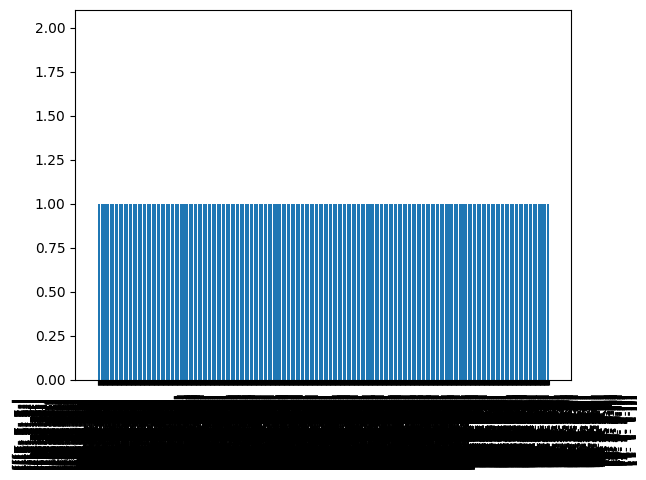

In [20]:
# Define parameters
J = 0.1  # coupling constant
k_B = 1.0  # Boltzmann constant
T = 1.0  # temperature
L = 3   # lattice size
N = L**2  # number of spins
n_steps = 1000  # number of simulation steps
dyct = {}

# Initialize the lattice
#s = np.random.choice([-1, 1], size=(L, L))
#s = [[1 for col in range(L)] for row in range(L)]
s = np.ones((L, L, L), dtype=int)

start = time()

# Monte Carlo simulation using the Metropolis algorithm
for step in range(n_steps):
    #Initialize Spin for every loop
    st = copy.deepcopy(s)
    
    # Calculate the energy change and perform ising interaction
    for i in range(L):
        for j in range(L):
            for k in range(L):
                if deltaEnergy(st, i, j, k) <= 0:
                    st[i][j][k] = -1 * st[i][j][k]
                else:
                    if random.random() < np.exp(-deltaEnergy(st, i, j, k)/(k_B*T)):
                        st[i][j][k] = -1 * st[i][j][k]
    # Added result to dictionary
    encode(dyct, st)
    

#print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in s]))
print(float(time() - start), 'seconds')
plotdyct(dyct)

In [21]:
print(len(dyct))

999


In [15]:
def withoutH31Dtest(xindex, yindex, zindex):
    
    # Initialize circuit
    qc = QuantumCircuit(q, c)
        
    qc.u(2 * np.arccos(np.sqrt(1 - P1)), 0, 0, q[11])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[12])
    qc.u(2 * np.arccos(np.sqrt(1 - P2)), 0, 0, q[13])

    if spins[xindex][yindex][zindex] == 1:
        qc.x(q[0])
            
    if spins[(xindex - 1) % L][yindex][zindex] == 1:
        qc.x(q[1])

    if spins[(xindex + 1) % L][yindex][zindex] == 1:
        qc.x(q[2])
    
    if spins[xindex][(yindex - 1) % L][zindex] == 1:
        qc.x(q[3])
    
    if spins[xindex][(yindex + 1) % L][zindex] == 1:
        qc.x(q[4])
    
    if spins[xindex][yindex][(zindex - 1) % L] == 1:
        qc.x(q[5])
    
    if spins[xindex][yindex][(zindex + 1) % L] == 1:
        qc.x(q[6])
    
    # Operation 1
    qc.mcx([q[0], q[1], q[2]], q[7])

    # Operation 2
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[7])
    qc.mcx([q[0], q[1], q[2]], q[7])
    qc.x(q[0])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[7])
    
    # Operation 3
    qc.mcx([q[0], q[3], q[4]], q[8])
    
    # Operation 4
    qc.x(q[0])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[8])
    qc.mcx([q[0], q[3], q[4]], q[8])
    qc.x(q[0])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[8])

    # Operation 5
    qc.mcx([q[0], q[5], q[6]], q[9])
    
    # Operation 6
    qc.x(q[0])
    qc.x(q[5])
    qc.x(q[6])
    qc.x(q[9])
    qc.mcx([q[0], q[5], q[6]], q[9])
    qc.x(q[0])
    qc.x(q[5])
    qc.x(q[6])
    qc.x(q[9])
 
    # Operation 7
    qc.x(q[5])
    qc.x(q[6])
    qc.mcx([q[1], q[2], q[3], q[4], q[5], q[6]], q[10])
    qc.x(q[5])
    qc.x(q[6])

    # Operation 8
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[1], q[2], q[3], q[4], q[5], q[6]], q[10])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[3])
    qc.x(q[4])

    # Operation 9
    qc.x(q[3])
    qc.x(q[4])
    qc.mcx([q[1], q[2], q[3], q[4], q[5], q[6]], q[10])
    qc.x(q[3])
    qc.x(q[4])

    # Operation 10
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[5])
    qc.x(q[6])
    qc.mcx([q[1], q[2], q[3], q[4], q[5], q[6]], q[10])
    qc.x(q[1])
    qc.x(q[2])
    qc.x(q[5])
    qc.x(q[6])

    # Operation 11
    qc.x(q[1])
    qc.x(q[2])
    qc.mcx([q[1], q[2], q[3], q[4], q[5], q[6]], q[10])
    qc.x(q[1])
    qc.x(q[2])

    # Operation 12
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    qc.x(q[6])
    qc.mcx([q[1], q[2], q[3], q[4], q[5], q[6]], q[10])
    qc.x(q[3])
    qc.x(q[4])
    qc.x(q[5])
    qc.x(q[6])

    # Operation 13
    qc.cx(q[10], q[0])
    
    # Operation 14
    qc.x(q[7])
    qc.x(q[8])
    qc.x(q[9])
    qc.mcx([q[7], q[8], q[9]], q[0])
    qc.x(q[7])
    qc.x(q[8])
    qc.x(q[9])

    # Operation 15
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[11]], q[0])
    qc.x(q[10])

    # Operation 16
    qc.x(q[9])
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[12]], q[0])
    qc.x(q[9])
    qc.x(q[10])

    # Operation 17
    qc.x(q[8])
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[12]], q[0])
    qc.x(q[8])
    qc.x(q[10])

    # Operation 18
    qc.x(q[7])
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[12]], q[0])
    qc.x(q[7])
    qc.x(q[10])

    # Operation 19
    qc.x(q[8])
    qc.x(q[9])
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[13]], q[0])
    qc.x(q[8])
    qc.x(q[9])
    qc.x(q[10])

    # Operation 20
    qc.x(q[7])
    qc.x(q[9])
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[13]], q[0])
    qc.x(q[7])
    qc.x(q[9])
    qc.x(q[10])

    # Operation 21
    qc.x(q[7])
    qc.x(q[8])
    qc.x(q[10])
    qc.mcx([q[7], q[8], q[9], q[10], q[13]], q[0])
    qc.x(q[7])
    qc.x(q[8])
    qc.x(q[10])
    
    # Operation 22
    qc.measure(q[0], c)
    backend = Aer.get_backend('qasm_simulator')
    shots = 1
    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts()

    newstat = int(list(counts.keys())[0])
    if newstat == 1:
        spins[xindex][yindex][zindex] = 1
    elif newstat == 0:
        spins[xindex][yindex][zindex] = -1

237.212331533432 seconds


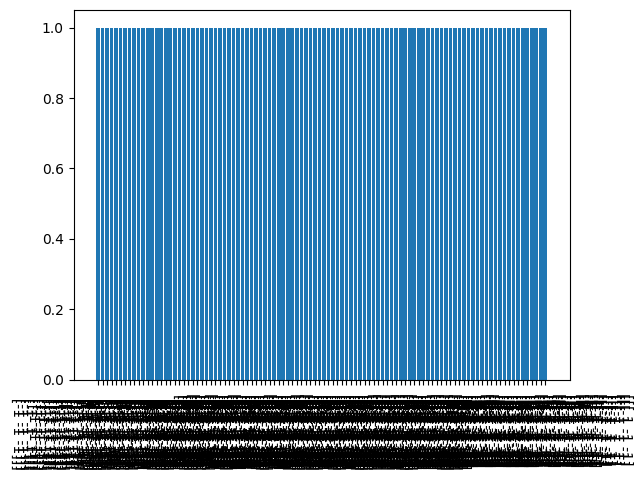

In [18]:
start = time()

dyct = {}

# Set Parameters
J = 0.1 # Coupling Strength
T = 1 # Temperature

# Calculate the Possibility
P1 = np.exp(-4 * J / T)
P2 = np.exp(-8 * J / T)
P3 = np.exp(-12 * J / T)

# Set the numbers of trials
trialnumbers = 100

# Initialize the circuit
q = QuantumRegister(14)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

# Initialized Spins
inispins = np.ones((L, L, L), dtype=int)

for totalloop in range(trialnumbers):
    
    spins = inispins.copy()
    
    for x in range (0, L):
        for y in range (0, L):
            for z in range (0, L):
                withoutH31Dtest(x, y, z)

    encode(dyct, spins)

print(float(time() - start), 'seconds')
plotdyct(dyct)

In [19]:
print(len(dyct))

100
